# Glosar
Apelant - persoană care a sunat serviciul call-centrului pentru anumite scopuri

Operator - persoană care deservește apelanții în cadrul call-centrului



# Analiza exploratorie a datelor șirurilor unul call-centru

Toate evenimentele de șir generate de Asterisk sunt inserate în cadrul unui fișier text, de obicei plasat în directoriul `/var/log/asterisk/queue_log`. Descrierile evenimentelor, conform [documentației Asterisk](https://wiki.asterisk.org/wiki/display/AST/Queue+Logs) sunt următoarele: 

`1366720340|1366720340.303267|MYQUEUE|SIP/8007|RINGNOANSWER|1000`

După cum vedem, fiecare eveniment conține mai multe câmpuri, separate prin simbolul „|”, numit „țeavă” sau „pipe”. Primele 5 câmpuri sunt similare pentru fiecare tip de eveniment:

- UNIX timestamp - numărul de secunde trecut de la 1 ianuarie 1970 pînă în momentul evenimentului
- Un număr de identificare unic pentru canalul de comunicare a apelantului, bazat de obicei pe UNIX timestamp. De asemenea sunt acceptate și numele "REALTIME" sau "NONE"
- Numele șirului în cadrul căruia au loc evenimentele
- Canalul operatorului din șir
- Tipul evenimentului
- Restul câmpurilor spre dreapta sunt parametrii evenimentelor, numărul lor diferă în funcție de tipul evenimentului.

Începem de la încărcarea datelor în memorie și o scurtă analiză:

In [1]:
def get_logs(filename):
    logs = []
    with open(filename, 'r') as f:
        log_fields = ('created', 'call_id', 'queue_name', 'agent', 'event_type',
              'data1', 'data2', 'data3', 'data4', 'data5')
        while True:
            new_data = f.readline()
            if not new_data:
                break
            odoo_log = {field: value for field, value in zip(
                        log_fields, new_data.split('|'))}
            logs.append(odoo_log)
    return logs


def count_events(event_list, event):
    counter = 0
    for queue_event in event_list:
        if queue_event['event_type'] == event:
            counter += 1
    return counter
    
logs = get_logs('queue_log')
call_events = ('ENTERQUEUE', 'CONNECT', 'RINGNOANSWER', 'COMPLETECALLER', 'COMPLETEAGENT', 
               'BLINDTRANSFER', 'ABANDON', 'EXITEMPTY', 'EXITWITHKEY', 'EXITWITHTIMEOUT')
calls_per_event = {event_name: count_events(logs, event_name) for event_name in call_events}
call_log = []
for log in logs:
    if log['event_type'] in call_events:
        call_log.append(log)
        
print('Numarul initial de evenimente: {}\nEvenimente legate de apeluri: {}\nRestul evenimentelor: {}'.format(len(logs), len(call_log), len(logs)-len(call_log)))

print('\n\nEvenimente per tip: {}'.format(calls_per_event))


Numarul initial de evenimente: 1249174
Evenimente legate de apeluri: 914878
Restul evenimentelor: 334296


Evenimente per tip: {'ENTERQUEUE': 265358, 'CONNECT': 221870, 'RINGNOANSWER': 167444, 'COMPLETECALLER': 84025, 'COMPLETEAGENT': 51083, 'BLINDTRANSFER': 81624, 'ABANDON': 43418, 'EXITEMPTY': 56, 'EXITWITHKEY': 0, 'EXITWITHTIMEOUT': 0}


Pentru fiecare tip de eveniment de mai sus, documentația Asterisk ne oferă o descriere succintă a câmpurilor disponibile:
  
- ENTERQUEUE(url|callerid) - Un apel a intrat pe șir. În log sunt plasate câmpurile url (dacă e specificat) și callerid.
- CONNECT(holdtime|bridgedchanneluniqueid|ringtime) - Apelantul a fost conectat cu succes la agent. Câmpul holdtime reprezintă cît timp apelantul a fost ținut în așteptare. bridgedchanneluniqueid reprezintă numărul de identificare unic a canalului din șir, care primește apelul. Acest lucru este util pentru legarea înregistrărilor apelurilor la un apel particular din șir. Cîmpul ringtime reprezintă timpul în care telefonul operatorului a sunat pînă la momentul în care a fost răspuns apelul.
- RINGNOANSWER(ringtime) - Operatorul spre care a fost direcționat apelul nu a răspuns, iar apelul este redirecționat spre alt operator. Se înregistrează  câmpul ringtime care denotă durata așteptării.
- COMPLETECALLER(holdtime|calltime|origposition) - Apelantul a fost unit cu succes la operator și apelul a fost terminat cu succes, din partea apelantului.Sunt înregistrate câmpurile holdtime(timpul în care apelantul a fost în așteptare), calltime (durata apelului) și origposition(poziția inițială a apelantului în șir).
- COMPLETEAGENT(holdtime|calltime|origposition) - Apelantul a fost unit cu succes la operator și apelul a fost terminat cu succes, din partea operatorului.Sunt înregistrate câmpurile holdtime(timpul în care apelantul a fost în așteptare), calltime (durata apelului) și origposition(poziția inițială a apelantului în șir).
- BLINDTRANSFER(extension|context|holdtime|calltime|origposition) - Un transfer de tip Blind transfer presupune transferul apelantului în afara șirului, de exemplu la un operator dedicat.
- ABANDON(position|origposition|waittime) - Apelantul și-a abandonat poziția în șir. Atributul position desemnează poziția apelantului în momentul în care el a închis apelul, origposition reprezintă poziția inițială a apelantului în momentul în care au intrat în șir, și waittime reprezintă timpul așteptării apelantului la momentul deconetării.
- EXITEMPTY(position|origposition|waittime) - Apelantul a fost eliminat forțat din șir fiindcă șirul nu are operatori. Sunt înregistrate câmpurile position(poziția curentă a apelantului în șir), origposition(poziția originală a apelantului), waittime(timpul de așteptare a apelantului).
- EXITWITHKEY(key|position|origposition|waittime) - Apelantul a ales să folosească un buton din meniu pentru a ieși din șir. Sunt înregistrate câmpurile key(butonul apăsat), position(poziția curentă a apelantului în șir), origposition(poziția originală a apelantului), waittime(timpul de așteptare a apelantului).
- EXITWITHTIMEOUT(position|origposition|waittime) - Apelantul a petrecut prea mult timp în așteptare în șirul dat și este eliminat. Sunt înregistrate câmpurile position(poziția curentă a apelantului în șir), origposition(poziția originală a apelantului), waittime(timpul de așteptare a apelantului).

In [2]:
unique_calls = {log['call_id'] for log in logs if log['event_type'] == 'ENTERQUEUE'}
print(len(unique_calls))

unique_queues = set(log['queue_name'] for log in logs)
print("Unique Queues: {}".format(unique_queues))

263778
Unique Queues: {'NONE', '50001', '50201', '50056', '50004', '50002', '50003', '50055', '50000', '50058', '50060', '50050', '50005', '50053'}


In [3]:
import odoorpc

cc_call_events = ['ENTERQUEUE', 'CONNECT', 'COMPLETECALLER']
ca_call_events = ['ENTERQUEUE', 'CONNECT', 'COMPLETEAGENT']

odoo = odoorpc.ODOO('queues', port=8072)
odoo.login('odoopbx_13', 'admin', 'admin')

QueueLog = odoo.env['asterisk_queues.queue_log']
QueueCall = odoo.env['asterisk_queues.queue_call']

all_calls = QueueCall.search([])
calls_set = set()
for call in all_calls:
    this_call = QueueCall.browse(call)
    call_events = tuple([
        event.event_type for event in QueueLog.browse(
        QueueLog.search([('call_id', '=', this_call.call_id)]))
    ])
    calls_set.add(call_events)

In [12]:
import datetime

hours = []
for call in unique_calls:
    if call not in ('NONE', 'CLI', 'MANAGER'):
        ts = int(call.split('.')[0])
        hours.append((
            datetime.datetime.fromtimestamp(ts).month,
            datetime.datetime.fromtimestamp(ts).day,
            datetime.datetime.fromtimestamp(ts).hour
        ))

In [13]:
print(len(calls_set))

905


In [15]:
from itertools import chain
from collections import Counter

counted_hours = Counter(chain(hours)).items()
#print(counted_hours)
chd = dict()
for hour in range(24):
    counter = 0
    le_sum = 0
    for cd in counted_hours:
        if cd[0][2] == hour:
            le_sum += cd[1]
            counter +=1
    chd[hour] = le_sum / counter

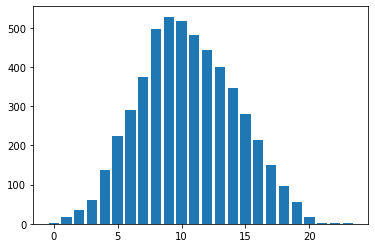

In [16]:
import matplotlib.pyplot as plt

plt.bar(list(range(24)), [chd[x] for x in range(24)])
plt.show()

Din imaginea de mai sus vedem rata medie a apelurilor, per oră. După formă, acest grafic este foarte aproape de distribuția normală. Aici vedem că începînd cu ora 21 și pînă la ora 1 practic nu sunt apeluri. Odată cu ora 2 începe a crește rata intrării apelurilor, atingînd valoarea maximă de 535 de apeluri dimineața la ora 9, scăzînd treptat după aceea.
Așa cum avem nevoie nu de rata apelurilor per oră, ci de timpul dintre apeluri, il calculăm în felul următor:

In [17]:
sorted_calls = sorted([float(call_id) for call_id in unique_calls if call_id not in ('CLI', 'MANAGER', 'NONE')])
incoming_rate = []
for n in range(len(sorted_calls)-1):
    incoming_rate.append(round((sorted_calls[n+1]-sorted_calls[n]), 1))
    
#print(incoming_rate)

Ne asigurăm că avem cu o valoare mai puțin decît numărul de evenimente

In [18]:
print(len(sorted_calls))
print(len(incoming_rate))

263778
263777


Pentru a ne fi mai comodă gruparea, rotunjim valorile timpului de așteptare dintre evenimente și numărăm cîte evenimente au același timp de așteptare

In [19]:
rc = Counter([round(rate) for rate in incoming_rate])
# print(rc.most_common())

Vedem mai jos vizualizarea duratei de așteptare dintre apeluri. Graficul seamănă vag distribuției exponențiale, ceea ce corespunde ipotezei inițiale că apelurile în cadrul unui call-centru corespund unui proces de tip Poisson.

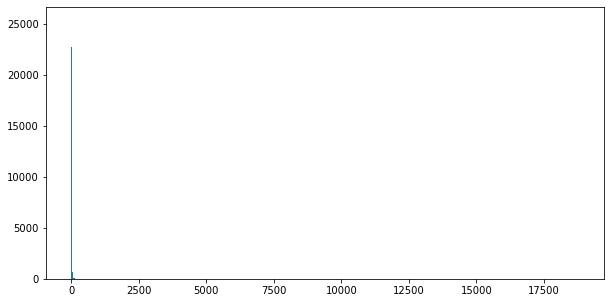

In [20]:
max_interval = max(incoming_rate)
unique_intervals = set(incoming_rate)
sorted_intervals = sorted(unique_intervals)

counted_intervals = [rc[x] for x in sorted_intervals]

plt.figure(figsize=(10, 5))
plt.bar(sorted_intervals, counted_intervals)
plt.show()

Pentru a îmbunătăți calitatea graficului, vom reduce valorile anormale, folosind ca bază inegalitatea lui Cebîșev: 

![](media/Cebyshev.png)


[1][Alexei Leahu, Ion Pârțachi; STATISTICA MATEMATICĂ ÎN ECONOMIE ȘI AFACERI (Prin exemple și probleme propuse)
Partea II. ANALIZA INFERENȚIALĂ A DATELOR STATISTICE]

Respectiv, calculînd inegalitatea lui Cebîșev pentru k=3, vom primi un grafic care va fi reprezentativ pentru cel puțin $ 1 - \frac{1}{3^2} = 88.89% $ dintre apeluri. Începem cu calcularea valoriei mediei eșantionului, modei, medianei și deviației standarte:

In [21]:
import numpy as np
from scipy import stats

print('Media de eșantion: {}, moda: {}, mediana: {}, abaterea standartă: {}'.format(
    np.average(incoming_rate),
    stats.mode(incoming_rate),
    np.median(incoming_rate),
    np.std(incoming_rate)))


Media de eșantion: 16.671833404732027, moda: ModeResult(mode=array([1.]), count=array([25361])), mediana: 7.0, abaterea standartă: 206.41591435430854


Apoi filtrăm apelurile care sunt la mai puțin de trei abateri standarte, folosind algoritmul z-score, inclus în librăria scipy:

In [22]:
filtered_rate = []
for i in zip(incoming_rate, stats.zscore(incoming_rate)):
    if abs(i[1]) < 3:
        filtered_rate.append(i[0])
print(len(filtered_rate))

263601


Vedem că am pierdut un număr mic de valori - 177. Totuși graficul rezultat este mult mai aproape de distribuția exponențială:

In [23]:
fc = Counter([rate for rate in filtered_rate])
#print(fc)

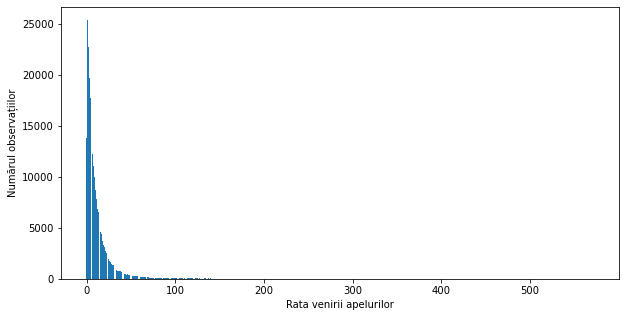

In [24]:
plt.figure(figsize=(10, 5))
plt.bar(list(range(572)), [rc[x] for x in range(572)])
plt.ylabel("Numărul observațiilor")
plt.xlabel('Rata venirii apelurilor')
plt.show()

# Analiza distribuțiilor apelurilor

Pentru a dovedi că valorile date într-adevăr pot fi atribuite unei distribuții statistice exponențiale, vom folosi testele legate de funcția empirică de distribuție.

Testele legate de funcția empirică de distribuție sunt astfel numite fiindcă ele sunt bazate pe compararea dintre funcția empirică de distribuție $ S_n $ (care va fi definită mai jos) și funcția ipotetică de distribuție, $ F $. Funcția $ S_n $ este definită în termenii unui eșantion aleatoriu din cadrul unei populații determinate de variabila aleatoare $ X $.

Fie o selecție de valori aleatorii de mărimea n, unde $ x_1, x_2, x_3, ..., x_n $. Vom începe prin sortarea acestor valori în ordine crescătoare. Respectiv, după sortare și renumărare (în caz că este necesar) $ x_1 <= x_2 <= x_3 <= ... <= x_n $. Apoi vom defini funcția empirică $ S_n $, prin

$$ S_n (x) = \frac{i}{n} (4)$$ 

unde $ i $ este numărul valorilor din eșantion, prin care $ x_m , m < i $ este $ <= x $. Deci, $ S_n $  este o funcție în trepte, care este egală cu zero pentru $ x $ mai mic decît cel mai mic $ x_i $ și are un salt de  $ \frac{1}{n} $ pentru fiecare $ x_i $ ( desigur cu excepția cazurilor cînd mai multe valori sunt egale $ x_i = x_{i+1} = ... x_{i+j} $, pentru un oarecare $ j>0 $, ceea ce duce la un salt egal cu $ \frac{(j+1)}{n} $ ) și este $ 1 $ pentru orice $ x $ care este mai mare sau egal cu cel mai mare $ x_i $.

Primul test care va fi utilizat este testul Kolmogorov-Smirnov. Testul Kolmogorov-Smirnov compară distanța verticală dintre funcția empirică $ S_n $ de distribuție și funcția ipotetică, $ F $, pentru fiecare punct $ x $. Există trei măsuri utilizate pentru a măsura diferențele dintre valorile rezultatelor funcțiilor:

$$ D^+ = \underset{x}{sup} \{ S_n(x) - F_n(x) \} (5) $$


$$ D^- = \underset{x}{sup} \{ F_n(x) - S_n(x) \} (6) $$


Și măsura utilizată cel mai frecvent - D, definită prin

$$ D = max\{ D^+, D^- \} (7) $$

Fiindcă $ S_n $ este o funcție non-descrescătoare în trepte și $ F $ este de asemenea non-descrescătoarea (din simplul motiv că este o funcție de distribuție), este suficient să calculăm numai (5) și (6) pentru mulțimea de puncte $ x_1, x_2, x_3, ..., x_n $. De fapt, 

$$ D^+ = \underset{i}{max}{ \frac{i}{n} - F(x_i) } (8) $$

și

$$ D^- = \underset{i}{max}{ F(x_i) - \frac{i}{n} } (9) $$

Aceste trei statistici de mai sus sunt denumite _statistici ale supremumului_. Mai este o clasă a statisticilor, denumită _statistici pătratice_. Cea mai des întîlnită statistică este statistica pătratică a lui Anderson-Darling, $ A^2 $, definită prin

$$ A^2 = n \int_{-\infty}^{\infty} (S_n(x) - F(x))^2F(x)(1-F(x))^{-1} dF(x)  (10) $$ 

[2][Allen, Arnold O. Probability, statistics, and queueing theory: with computer science applications / Arnold O. Allen. — 2nd ed. p. cm. — (Computer science and scientific computing) ISBN 0-12-051051-0]

Desigur, aceste statistici de mai sus sunt disponibile de asemenea și în pachetele matematice, iar în lucrarea dată va fi folosită librăria [scipy](https://www.scipy.org/scipylib/index.html). Scipy oferă un set larg de instrumente fundamentale matematice, care includ și calcularea distribuțiilor statistice. Testul Kolmogorov-Smirnov este disponibil prin apelarea **[scipy.stats.kstest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest)**, iar statistica lui Anderson-Darling - **[scipy.stats.anderson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)**.

## Analiza distribuției apelurilor de intrare

Vom începe de la verificarea dacă apelurile per ansamblu corespund distribuției exponențiale, așa cum reiese din graficele de mai sus. Vom stabili două ipoteze:

1. $ H_0 $ - valorile distanțelor dintre apeluri corespund distribuției exponențiale
2. $ H_1 $ - valorile date nu corespund distribuției exponențiale

Mai jos vedem utilizarea testului Kolmogorov-Smirnov pentru a aprecia apartenența valorilor la distribuția exponențială.

In [25]:
from scipy.stats import kstest, anderson, expon

first_call = QueueCall.search([], order='call_id desc', limit=1)
last_call = QueueCall.search([], order='call_id asc', limit=1)

In [26]:
nr_seconds = (float(QueueCall.browse(first_call).call_id) -
            float(QueueCall.browse(last_call).call_id))

average_rate = len(unique_calls) / nr_seconds
print('Rata medie a apelurilor de intrare: {}'.format(average_rate))

Rata medie a apelurilor de intrare: 0.059981505980204165


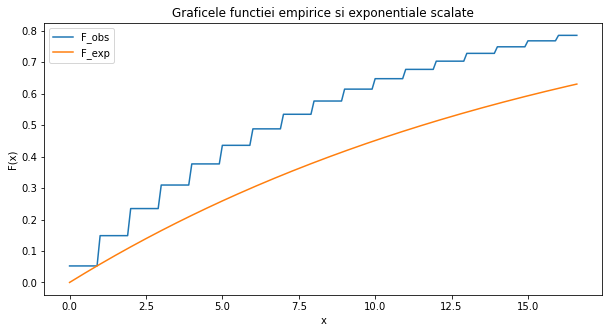

In [27]:
from statsmodels.distributions.empirical_distribution import ECDF
x_vals = np.arange(0, 1/average_rate, 10**-1)

ecdf = ECDF(filtered_rate)
exp_dist = expon.cdf(x_vals, scale=1/average_rate)
obs_dist = ecdf(x_vals)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, obs_dist, label='F_obs')
plt.plot(x_vals, exp_dist, label='F_exp')
plt.legend()
plt.ylabel("F(x)")
plt.xlabel('x')
plt.title("Graficele functiei empirice si exponentiale scalate")
plt.show()

In [28]:
kstest(incoming_rate, lambda x: expon.cdf(x, scale=1/average_rate))

KstestResult(statistic=0.1968752896106959, pvalue=0.0)

Prima valoare returnată este valoarea statisticii - diferența maximă dintre distribuția exponențială, a doua valoare - valoarea P.  Valoarea P este probabilitatea că, în cazul în care ipoteza nulă este adevărată, va fi observată o valoare cel puțin de mărimea statisticii test observate. În acest caz regula de acceptare sau nu a apartenenței statisticii devine: dacă valoarea P este mai mică decît valoarea statisticii, ipoteza nulă este respinsă.
Respectiv, în cazul de mai sus, respingem ipoteza nulă conform căreia totalitatea valorilor pentru t dintre apeluri este conformă distribuției exponențiale.

Deoarece ipoteza nulă a eșuat, dar totuși graficul corespunde curbei funcției exponențiale, vom continua explorarea datelor prin modificarea ipotezei nule:

1. $ H_0 $: Valorile distanțelor dintre apeluri corespund unei funcții exponențiale în trepte 
2. $ H_1 $: Valorile distanțelor dintre apeluri nu corespund 

Următorul pas este verificarea ipotezei că apelurile recepționate pe 30 noiembrie 2020, între orele 8 și 9 corespund unei distribuții exponențiale. Pentru aceasta mai întîi filtrăm apelurile.

Începem prin calcularea distanțelor dintre apeluri care au avut loc în perioada de timp vizată:

In [76]:
def get_interval_values(first_day, last_day, interval_start, interval_end):
    """
    Returns interarrival values for a number of days between first_day and last_day
    for the hours between interval_start and interval_end
    """
    first_day = datetime.date.fromisoformat(first_day)
    last_day = datetime.date.fromisoformat(last_day)
    a_day = datetime.timedelta(hours=24)
    days = []
    hours = []
    temp_day = first_day
    while temp_day <= last_day:
        days.append(temp_day)
        temp_day += a_day
    
    intervals = []
    for day in days:
        calls = QueueCall.search([
            ('create_date', '>', '{} {}'.format(day.isoformat(), interval_start)),
            ('create_date','<','{} {}'.format(day.isoformat(), interval_end))],
            order='create_date asc'
        )
        # print('On {} we got {} calls'.format(day.isoformat(), len(calls)))
        # print(calls)
        for n in range(len(calls)-1):
            intervals.append(float(QueueCall.browse(calls[n+1]).call_id)-float(QueueCall.browse(calls[n]).call_id))
    return intervals
        

In [77]:
morning_calls = get_interval_values('2020-10-10', '2020-11-30', '04:00:00', '04:30:00')
# print(morning_calls)
# all_calls = QueueCall.search([
#     ('create_date', '>', '2020-10-30 00:08:00'),
#     ('create_date','<','2020-10-30 00:09:00')])

După aceasta, pe baza ipotezei nule, folosim testul Kolmogorov-Smirnov pentru a verifica apartenența valorilor la funcția exponențială

0.08865597186311357


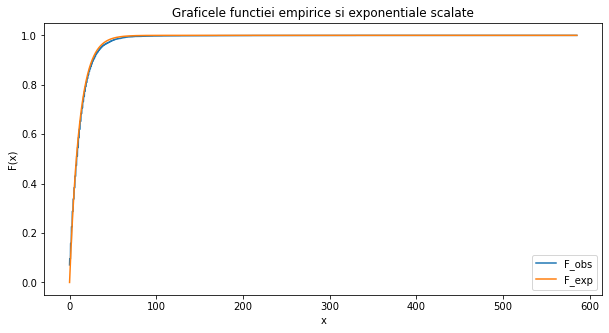

In [84]:
x_vals = np.arange(0, max(morning_calls), 10**-1)
average_rate = len(morning_calls)/sum(morning_calls)
print(average_rate)

ecdf = ECDF(morning_calls)
exp_dist = expon.cdf(x_vals, scale=1/average_rate)
obs_dist = ecdf(x_vals)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, obs_dist, label='F_obs')
plt.plot(x_vals, exp_dist, label='F_exp')
plt.legend()
plt.ylabel("F(x)")
plt.xlabel('x')
plt.title("Graficele functiei empirice si exponentiale scalate")
plt.show()

In [83]:
kstest(morning_calls, lambda x: expon.cdf(x, scale=1/average_rate))

KstestResult(statistic=0.09562588488727276, pvalue=2.277119287434975e-64)

Numarul de apeluri din intervalul 00:00:00 - 00:30:00: 832
Rata medie a apelurilor pentru intervalul 00:00:00-00:30:00: 95.91336382425219


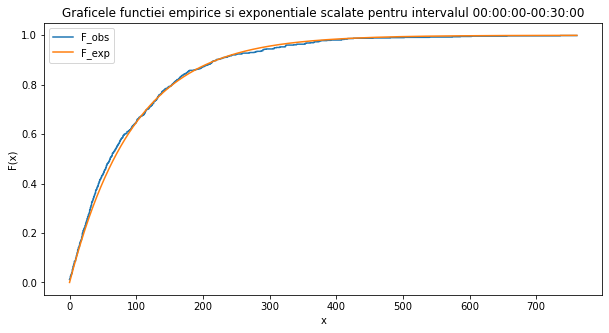

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 00:00:00 - 00:30:00: KstestResult(statistic=0.040681535392613044, pvalue=0.12429631545271969)
Numarul de apeluri din intervalul 00:30:00 - 01:00:00: 1014
Rata medie a apelurilor pentru intervalul 00:30:00-01:00:00: 80.75123974625002


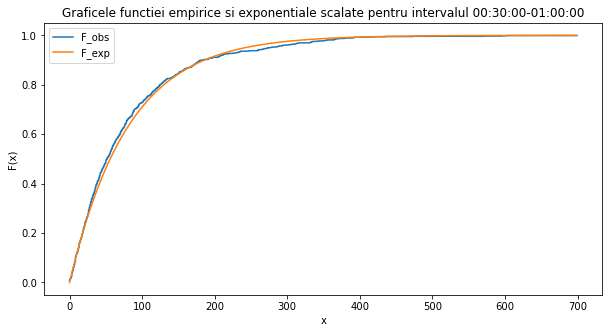

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 00:30:00 - 01:00:00: KstestResult(statistic=0.037689529092265917, pvalue=0.10966090813001939)
Numarul de apeluri din intervalul 01:00:00 - 01:30:00: 1545
Rata medie a apelurilor pentru intervalul 01:00:00-01:30:00: 55.133426847853194


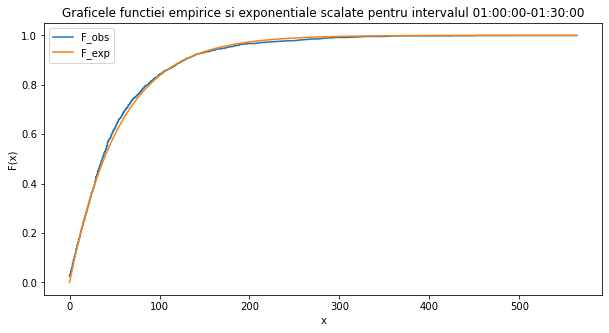

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 01:00:00 - 01:30:00: KstestResult(statistic=0.03486454719926091, pvalue=0.045768192184685974)
Numarul de apeluri din intervalul 01:30:00 - 02:00:00: 1951
Rata medie a apelurilor pentru intervalul 01:30:00-02:00:00: 45.2179574017647


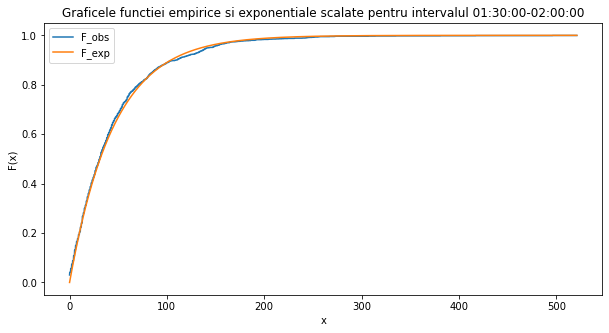

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 01:30:00 - 02:00:00: KstestResult(statistic=0.04102553029994328, pvalue=0.002739467021277398)
Numarul de apeluri din intervalul 02:00:00 - 02:30:00: 4236
Rata medie a apelurilor pentru intervalul 02:00:00-02:30:00: 21.106975864829252


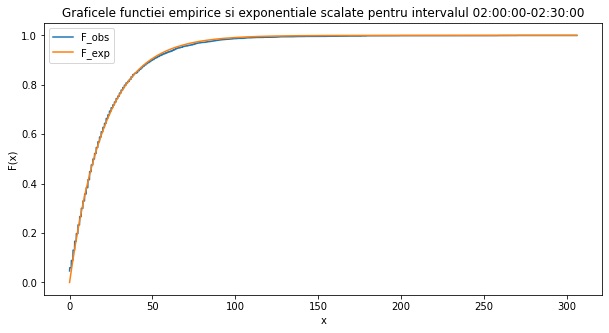

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 02:00:00 - 02:30:00: KstestResult(statistic=0.05950270897116241, pvalue=1.7794960507921133e-13)
Numarul de apeluri din intervalul 02:30:00 - 03:00:00: 4653
Rata medie a apelurilor pentru intervalul 02:30:00-03:00:00: 19.273656694671764


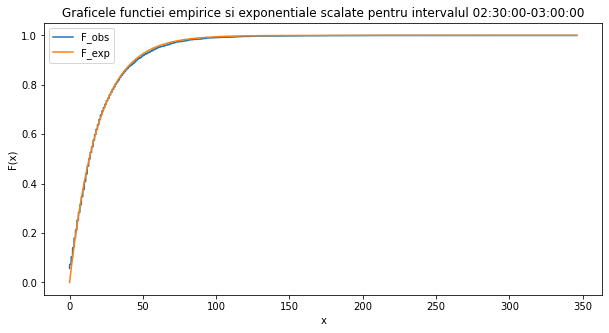

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 02:30:00 - 03:00:00: KstestResult(statistic=0.0730858052735359, pvalue=4.696386642413561e-22)
Numarul de apeluri din intervalul 03:00:00 - 03:30:00: 5857
Rata medie a apelurilor pentru intervalul 03:00:00-03:30:00: 15.384920481449921


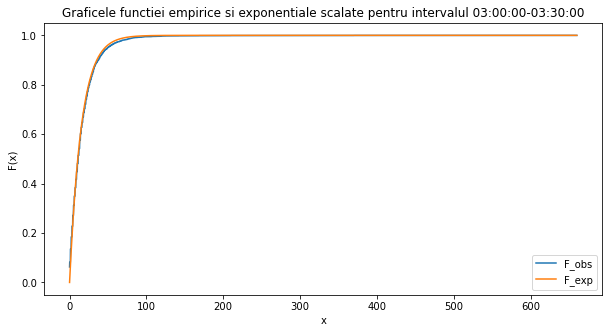

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 03:00:00 - 03:30:00: KstestResult(statistic=0.08196526050722036, pvalue=1.134970396012186e-34)
Numarul de apeluri din intervalul 03:30:00 - 04:00:00: 6354
Rata medie a apelurilor pentru intervalul 03:30:00-04:00:00: 14.15616253092967


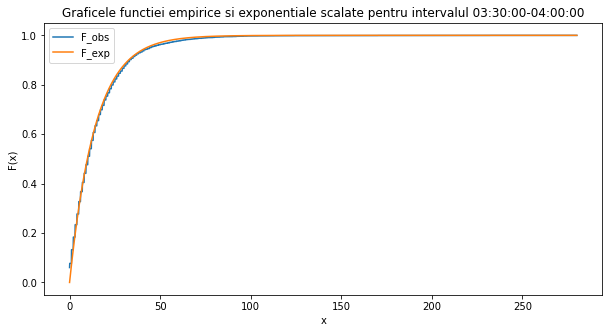

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 03:30:00 - 04:00:00: KstestResult(statistic=0.07712539549396932, pvalue=2.5855365162678743e-33)
Numarul de apeluri din intervalul 04:00:00 - 04:30:00: 8032
Rata medie a apelurilor pentru intervalul 04:00:00-04:30:00: 11.27955600716913


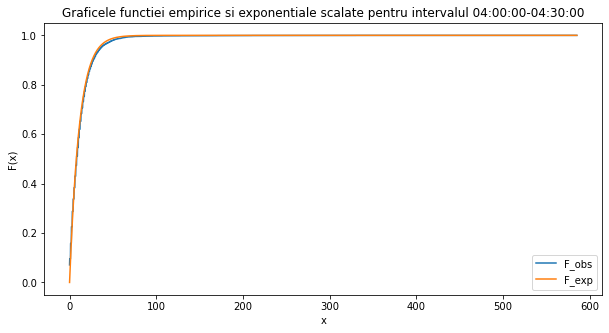

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 04:00:00 - 04:30:00: KstestResult(statistic=0.09562588488727276, pvalue=2.277119287434975e-64)
Numarul de apeluri din intervalul 04:30:00 - 05:00:00: 8251
Rata medie a apelurilor pentru intervalul 04:30:00-05:00:00: 10.978316065268082


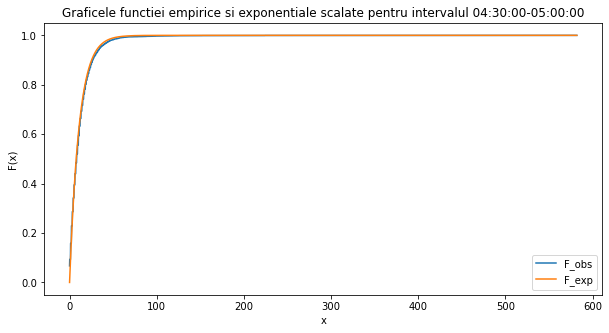

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 04:30:00 - 05:00:00: KstestResult(statistic=0.09320938484529712, pvalue=7.906598887214454e-63)
Numarul de apeluri din intervalul 05:00:00 - 05:30:00: 9776
Rata medie a apelurilor pentru intervalul 05:00:00-05:30:00: 9.289424407768736


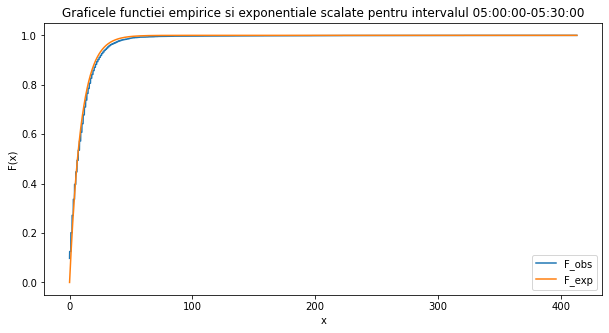

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 05:00:00 - 05:30:00: KstestResult(statistic=0.12511283094449893, pvalue=7.91541079781325e-134)
Numarul de apeluri din intervalul 05:30:00 - 06:00:00: 10552
Rata medie a apelurilor pentru intervalul 05:30:00-06:00:00: 8.625924542847093


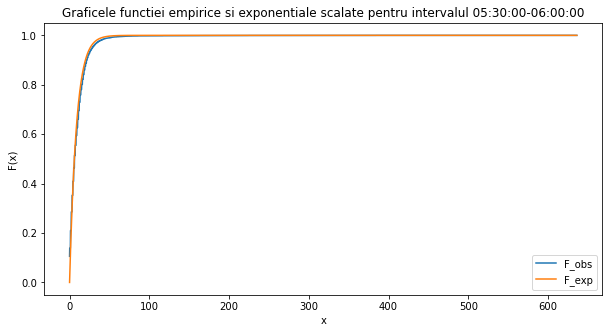

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 05:30:00 - 06:00:00: KstestResult(statistic=0.13846448284150437, pvalue=6.351032801868345e-177)
Numarul de apeluri din intervalul 06:00:00 - 06:30:00: 13599
Rata medie a apelurilor pentru intervalul 06:00:00-06:30:00: 6.696585557867208


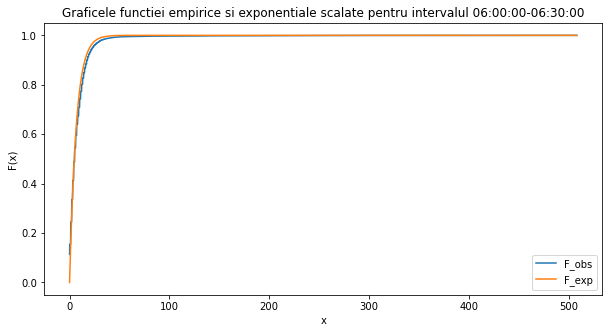

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 06:00:00 - 06:30:00: KstestResult(statistic=0.15435644946292493, pvalue=2.1970893605255757e-283)
Numarul de apeluri din intervalul 06:30:00 - 07:00:00: 13240
Rata medie a apelurilor pentru intervalul 06:30:00-07:00:00: 6.876741021572171


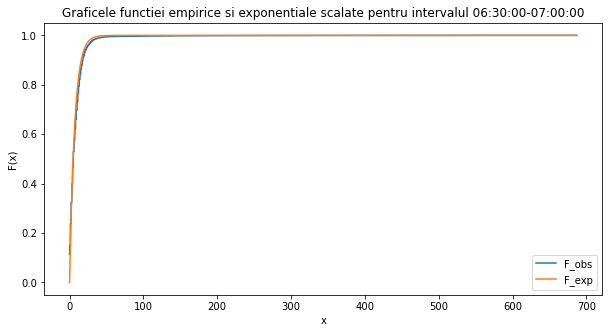

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 06:30:00 - 07:00:00: KstestResult(statistic=0.15015511823914207, pvalue=4.767038319831942e-261)
Numarul de apeluri din intervalul 07:00:00 - 07:30:00: 13546
Rata medie a apelurilor pentru intervalul 07:00:00-07:30:00: 6.712976493286267


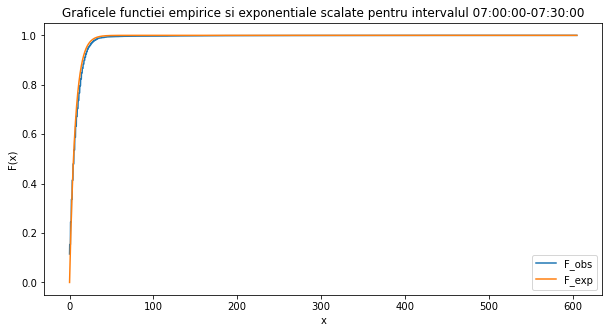

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 07:00:00 - 07:30:00: KstestResult(statistic=0.1533359569886388, pvalue=1.50872592979155e-278)
Numarul de apeluri din intervalul 07:30:00 - 08:00:00: 13060
Rata medie a apelurilor pentru intervalul 07:30:00-08:00:00: 6.979566610793314


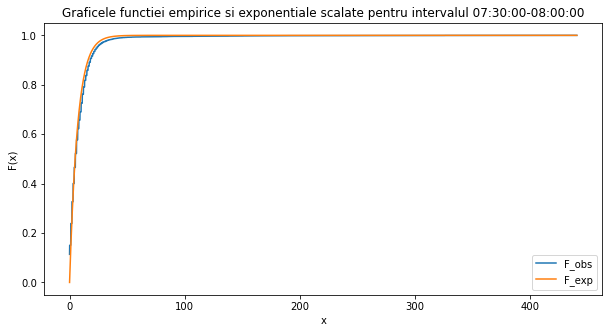

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 07:30:00 - 08:00:00: KstestResult(statistic=0.15039005995106203, pvalue=2.5823760301769915e-258)
Numarul de apeluri din intervalul 08:00:00 - 08:30:00: 13063
Rata medie a apelurilor pentru intervalul 08:00:00-08:30:00: 6.98156239062461


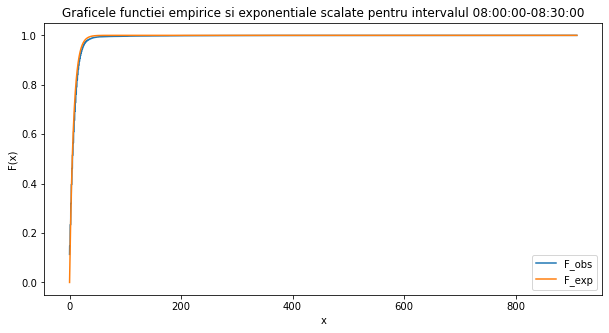

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 08:00:00 - 08:30:00: KstestResult(statistic=0.14851812862195032, pvalue=5.829310067589301e-252)
Numarul de apeluri din intervalul 08:30:00 - 09:00:00: 12614
Rata medie a apelurilor pentru intervalul 08:30:00-09:00:00: 7.238021706831613


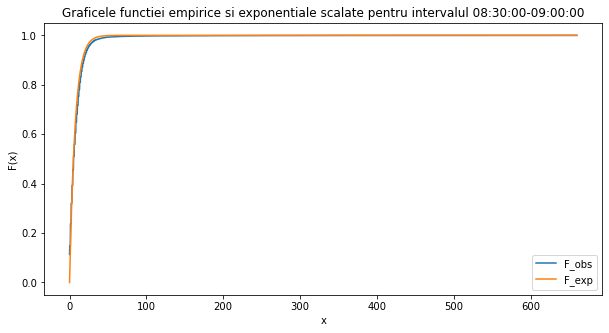

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 08:30:00 - 09:00:00: KstestResult(statistic=0.14793706504427998, pvalue=2.0738268795250406e-241)
Numarul de apeluri din intervalul 09:00:00 - 09:30:00: 12342
Rata medie a apelurilor pentru intervalul 09:00:00-09:30:00: 7.363494891554694


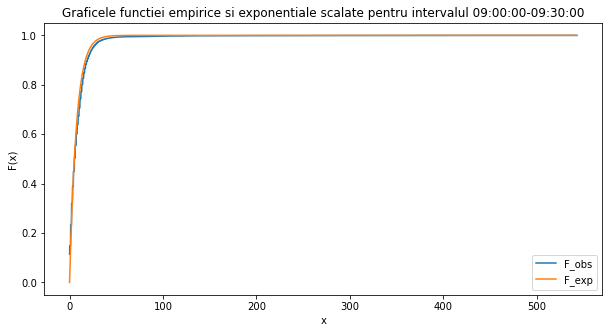

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 09:00:00 - 09:30:00: KstestResult(statistic=0.14820109008248275, pvalue=4.6374702321624405e-237)
Numarul de apeluri din intervalul 09:30:00 - 10:00:00: 11826
Rata medie a apelurilor pentru intervalul 09:30:00-10:00:00: 7.681541213122281


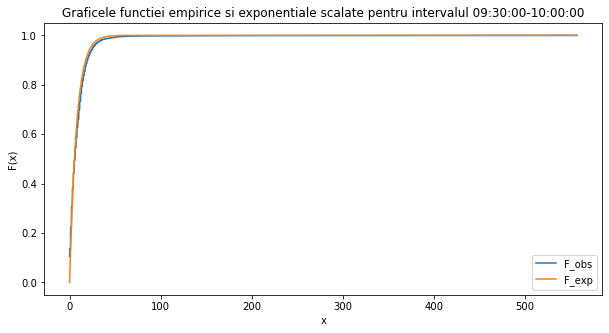

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 09:30:00 - 10:00:00: KstestResult(statistic=0.1367440841255712, pvalue=2.515702810854733e-193)
Numarul de apeluri din intervalul 10:00:00 - 10:30:00: 11343
Rata medie a apelurilor pentru intervalul 10:00:00-10:30:00: 8.018893849280035


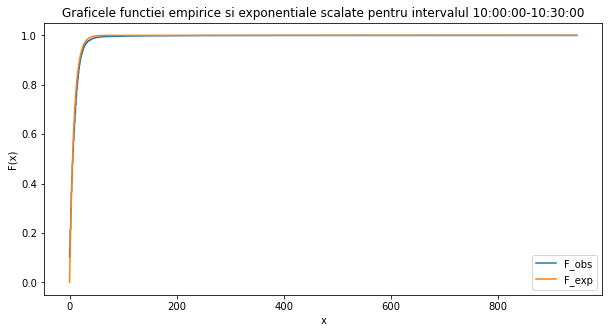

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 10:00:00 - 10:30:00: KstestResult(statistic=0.13514761106776327, pvalue=3.8958211269284236e-181)
Numarul de apeluri din intervalul 10:30:00 - 11:00:00: 10603
Rata medie a apelurilor pentru intervalul 10:30:00-11:00:00: 8.556338832572234


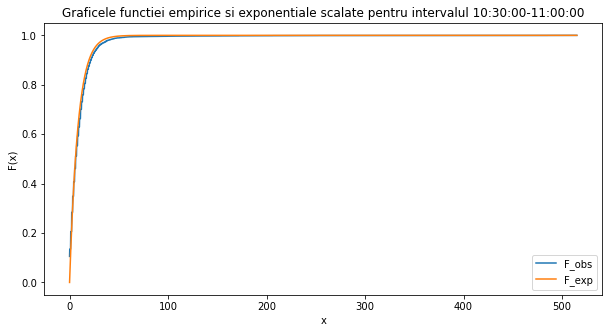

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 10:30:00 - 11:00:00: KstestResult(statistic=0.13486268462901382, pvalue=1.2385923501338032e-168)
Numarul de apeluri din intervalul 11:00:00 - 11:30:00: 10263
Rata medie a apelurilor pentru intervalul 11:00:00-11:30:00: 8.832358239338753


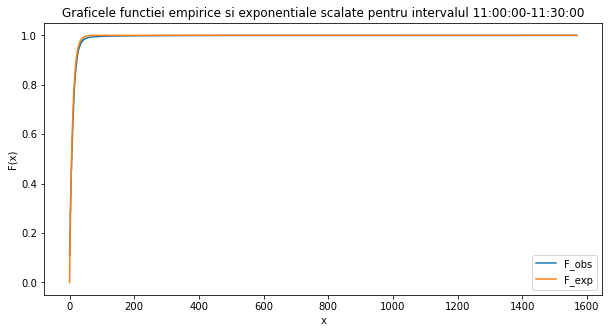

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 11:00:00 - 11:30:00: KstestResult(statistic=0.13893095114360218, pvalue=2.9700778137486337e-173)
Numarul de apeluri din intervalul 11:30:00 - 12:00:00: 9538
Rata medie a apelurilor pentru intervalul 11:30:00-12:00:00: 9.516566548292975


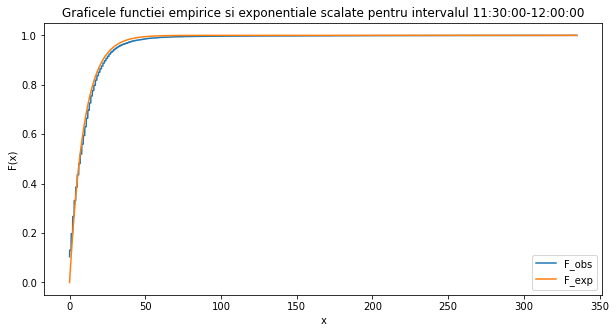

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 11:30:00 - 12:00:00: KstestResult(statistic=0.12991483057852699, pvalue=8.426225949788738e-141)
Numarul de apeluri din intervalul 12:00:00 - 12:30:00: 8582
Rata medie a apelurilor pentru intervalul 12:00:00-12:30:00: 10.537726750060989


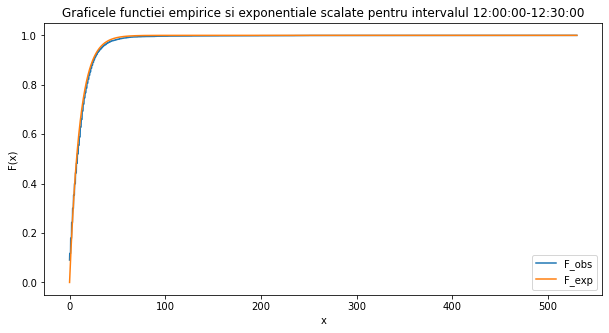

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 12:00:00 - 12:30:00: KstestResult(statistic=0.11727906398522797, pvalue=2.738884553075089e-103)
Numarul de apeluri din intervalul 12:30:00 - 13:00:00: 7700
Rata medie a apelurilor pentru intervalul 12:30:00-13:00:00: 11.752396928039305


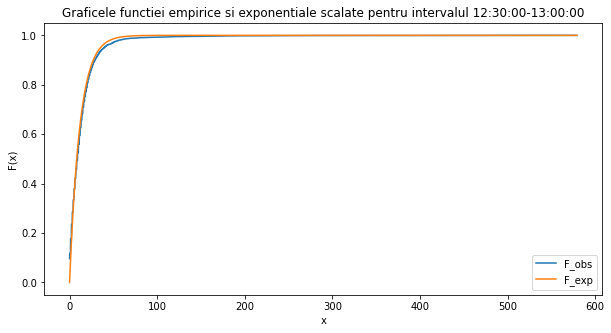

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 12:30:00 - 13:00:00: KstestResult(statistic=0.11777346678991761, pvalue=1.6792253255557672e-93)
Numarul de apeluri din intervalul 13:00:00 - 13:30:00: 7093
Rata medie a apelurilor pentru intervalul 13:00:00-13:30:00: 12.751878372673524


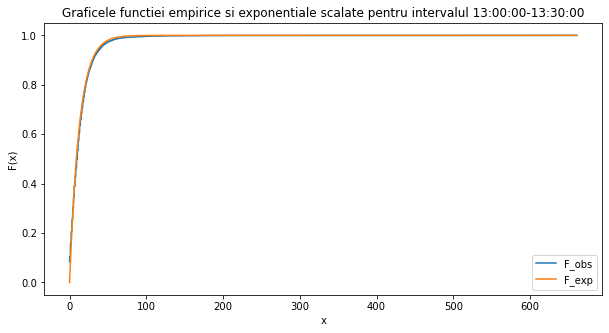

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 13:00:00 - 13:30:00: KstestResult(statistic=0.10403739348083621, pvalue=2.7337928865651436e-67)
Numarul de apeluri din intervalul 13:30:00 - 14:00:00: 6231
Rata medie a apelurilor pentru intervalul 13:30:00-14:00:00: 14.446123268133563


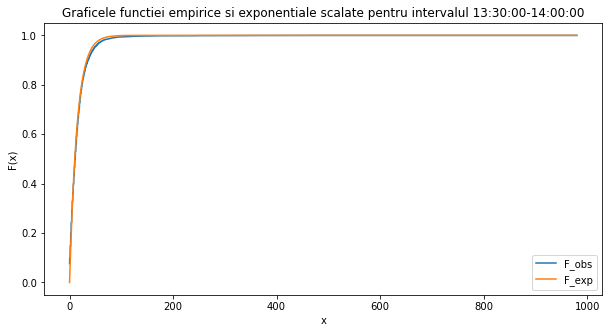

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 13:30:00 - 14:00:00: KstestResult(statistic=0.0969433256253164, pvalue=2.0531832029166884e-51)
Numarul de apeluri din intervalul 14:00:00 - 14:30:00: 5199
Rata medie a apelurilor pentru intervalul 14:00:00-14:30:00: 17.352074152004175


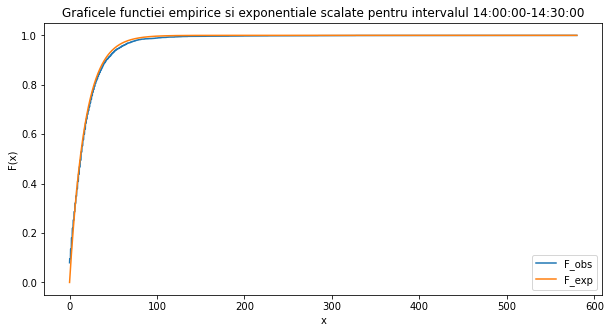

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 14:00:00 - 14:30:00: KstestResult(statistic=0.09561196632964525, pvalue=8.258921558852882e-42)
Numarul de apeluri din intervalul 14:30:00 - 15:00:00: 4295
Rata medie a apelurilor pentru intervalul 14:30:00-15:00:00: 20.736160790192898


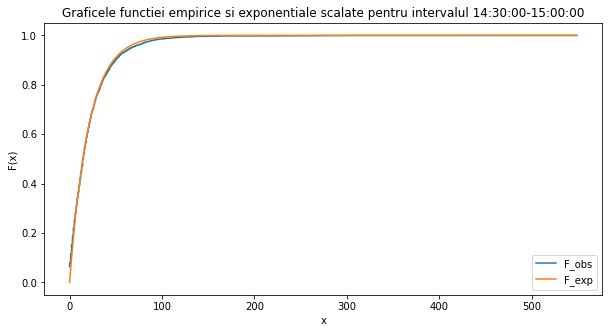

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 14:30:00 - 15:00:00: KstestResult(statistic=0.07847967062051471, pvalue=1.8894770420476432e-23)
Numarul de apeluri din intervalul 15:00:00 - 15:30:00: 3770
Rata medie a apelurilor pentru intervalul 15:00:00-15:30:00: 23.548167626590175


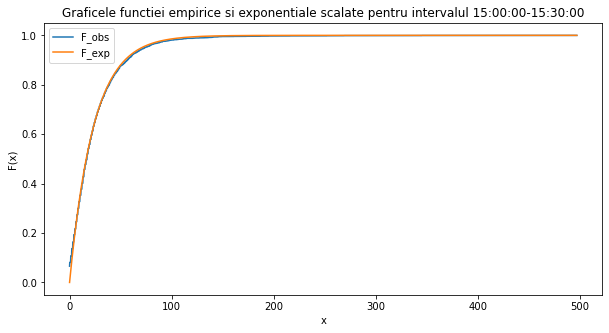

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 15:00:00 - 15:30:00: KstestResult(statistic=0.08118736848893181, pvalue=4.663653822481356e-22)
Numarul de apeluri din intervalul 15:30:00 - 16:00:00: 2963
Rata medie a apelurilor pentru intervalul 15:30:00-16:00:00: 29.9703007656364


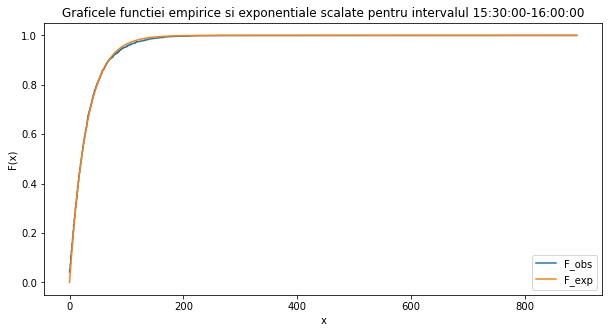

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 15:30:00 - 16:00:00: KstestResult(statistic=0.05165395352676213, pvalue=2.6184272740915753e-07)
Numarul de apeluri din intervalul 16:00:00 - 16:30:00: 2336
Rata medie a apelurilor pentru intervalul 16:00:00-16:30:00: 37.73319974241726


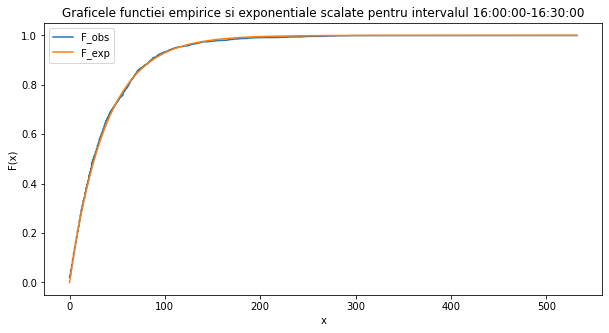

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 16:00:00 - 16:30:00: KstestResult(statistic=0.029121790296043493, pvalue=0.03735923918153261)
Numarul de apeluri din intervalul 16:30:00 - 17:00:00: 1889
Rata medie a apelurilor pentru intervalul 16:30:00-17:00:00: 45.63083584783441


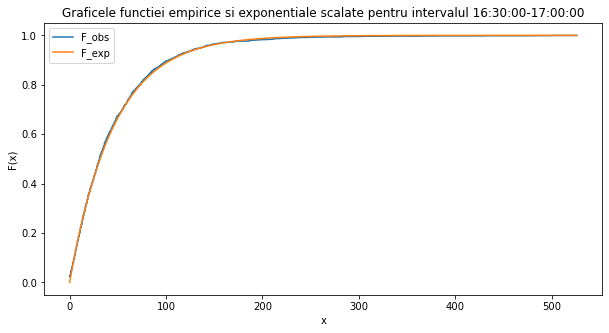

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 16:30:00 - 17:00:00: KstestResult(statistic=0.028601475467614556, pvalue=0.08935424505545675)
Numarul de apeluri din intervalul 17:00:00 - 17:30:00: 1319
Rata medie a apelurilor pentru intervalul 17:00:00-17:30:00: 64.0022842562072


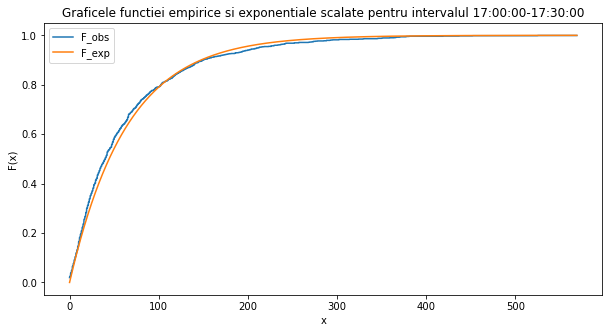

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 17:00:00 - 17:30:00: KstestResult(statistic=0.0511217325394458, pvalue=0.0019639292685448414)
Numarul de apeluri din intervalul 17:30:00 - 18:00:00: 752
Rata medie a apelurilor pentru intervalul 17:30:00-18:00:00: 99.03862503174935


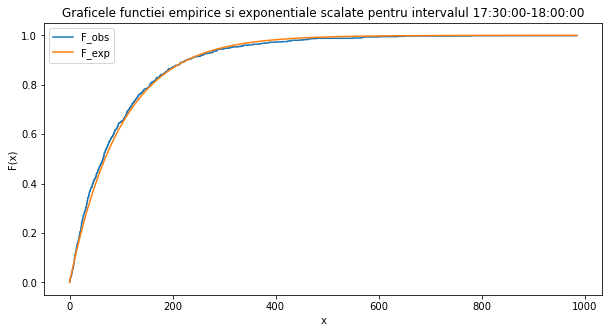

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 17:30:00 - 18:00:00: KstestResult(statistic=0.04619034165639069, pvalue=0.07863941430614918)
Numarul de apeluri din intervalul 18:00:00 - 18:30:00: 44
Rata medie a apelurilor pentru intervalul 18:00:00-18:30:00: 275.58140521825743


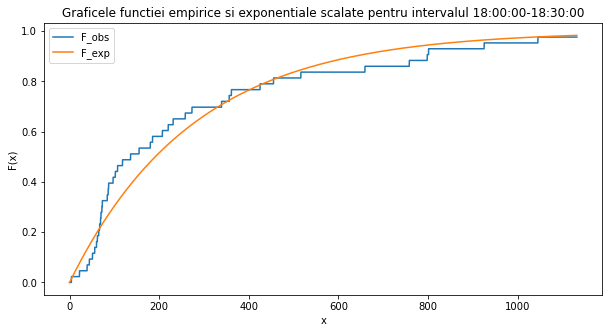

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 18:00:00 - 18:30:00: KstestResult(statistic=0.14334545419363343, pvalue=0.3096735045032104)
Numarul de apeluri din intervalul 18:30:00 - 19:00:00: 18
Rata medie a apelurilor pentru intervalul 18:30:00-19:00:00: 210.00001222947063


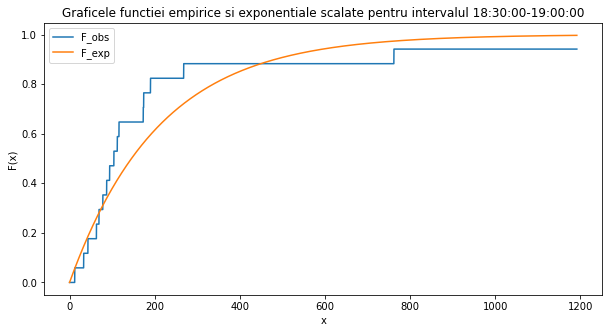

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 18:30:00 - 19:00:00: KstestResult(statistic=0.2281676427202589, pvalue=0.2922559126871389)
Numarul de apeluri din intervalul 19:00:00 - 19:30:00: 3
Rata medie a apelurilor pentru intervalul 19:00:00-19:30:00: 184.00000417232513


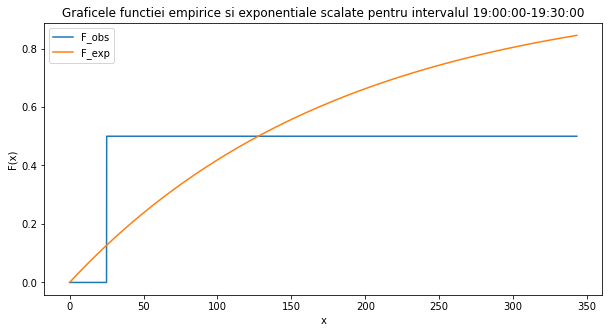

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 19:00:00 - 19:30:00: KstestResult(statistic=0.3729564859868413, pvalue=0.8790536204301417)
Numarul de apeluri din intervalul 19:30:00 - 20:00:00: 3
Rata medie a apelurilor pentru intervalul 19:30:00-20:00:00: 166.0000034570694


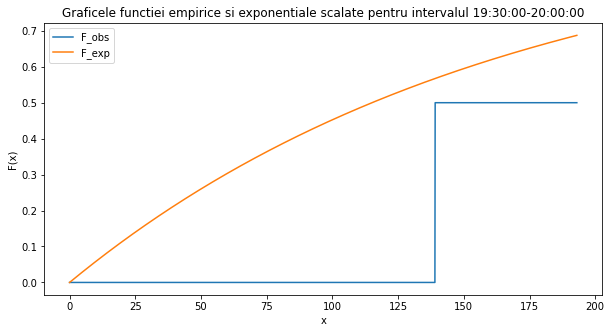

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 19:30:00 - 20:00:00: KstestResult(statistic=0.5671436712508495, pvalue=0.37472920267638526)
Numarul de apeluri din intervalul 20:00:00 - 20:30:00: 1
Numarul de apeluri din intervalul 20:30:00 - 21:00:00: 2
Numarul de apeluri din intervalul 21:00:00 - 21:30:00: 1
Numarul de apeluri din intervalul 21:30:00 - 22:00:00: 3
Rata medie a apelurilor pentru intervalul 21:30:00-22:00:00: 40.500001072883606


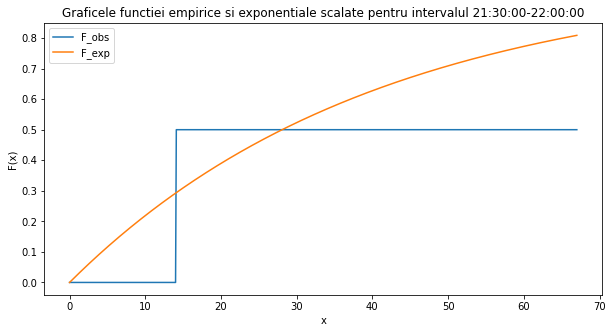

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 21:30:00 - 22:00:00: KstestResult(statistic=0.3087781458670287, pvalue=0.9723610365474744)
Numarul de apeluri din intervalul 22:00:00 - 22:30:00: 2
Numarul de apeluri din intervalul 22:30:00 - 23:00:00: 93
Rata medie a apelurilor pentru intervalul 22:30:00-23:00:00: 354.0217456843542


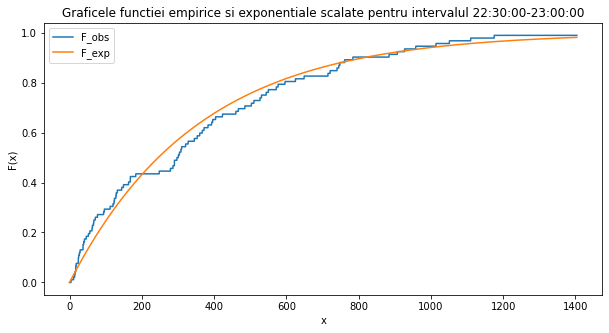

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 22:30:00 - 23:00:00: KstestResult(statistic=0.09963408004977814, pvalue=0.3003385795203545)
Numarul de apeluri din intervalul 23:00:00 - 23:30:00: 595
Rata medie a apelurilor pentru intervalul 23:00:00-23:30:00: 121.37710901181705


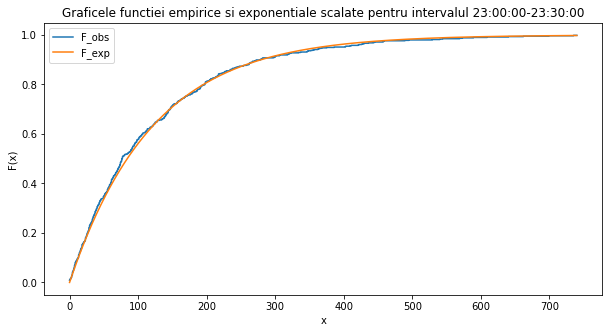

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 23:00:00 - 23:30:00: KstestResult(statistic=0.03867810497948365, pvalue=0.3281540103751074)
Numarul de apeluri din intervalul 23:30:00 - 23:59:59: 644
Rata medie a apelurilor pentru intervalul 23:30:00-23:59:59: 114.87247889779775


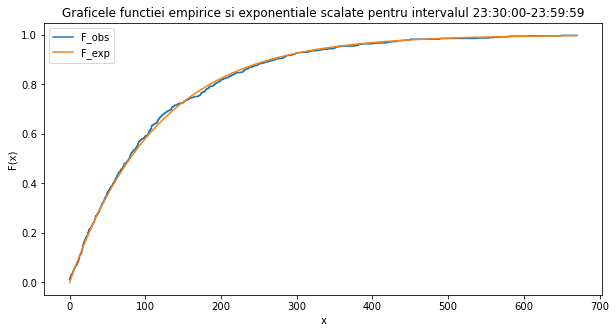

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 23:30:00 - 23:59:59: KstestResult(statistic=0.023255935894812896, pvalue=0.8693792480047496)


In [107]:
intervals = []
for hour in range(24):
    intervals.append(('{0:02d}:00:00'.format(hour),'{0:02d}:30:00'.format(hour)))
    if hour < 23:
        intervals.append(('{0:02d}:30:00'.format(hour),'{0:02d}:00:00'.format(hour+1)))
    else:
        intervals.append(('{0:02d}:30:00'.format(hour),'{0:02d}:59:59'.format(hour)))
    

for interval in intervals:
    interval_calls = get_interval_values(
        '2020-10-10', '2020-11-30', interval[0], interval[1])
    print('Numarul de apeluri din intervalul {} - {}: {}'.format(
        interval[0], interval[1], len(interval_calls)+1))
    if len(interval_calls) < 2:
        continue
    
    # Generate graph 
    x_vals = np.arange(0, max(interval_calls), 10**-1)
    average_rate = len(interval_calls)/sum(interval_calls)
    print("Rata medie a apelurilor pentru intervalul {}-{}: {}".format(
        interval[0], interval[1], 1/average_rate))

    ecdf = ECDF(interval_calls)
    exp_dist = expon.cdf(x_vals, scale=1/average_rate)
    obs_dist = ecdf(x_vals)

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, obs_dist, label='F_obs')
    plt.plot(x_vals, exp_dist, label='F_exp')
    plt.legend()
    plt.ylabel("F(x)")
    plt.xlabel('x')
    plt.title("Graficele functiei empirice si exponentiale scalate pentru intervalul {}-{}".format(
        interval[0], interval[1]))
    plt.show()
    
    # Compute KS
    print('Rezultatele testului Kolmogorov-Smirnov pentru intervalul {} - {}: {}'.format(
        interval[0], interval[1],
        kstest(interval_calls, lambda x: expon.cdf(x, scale=1/average_rate))))

## Analiza ratei de prelucrare a apelurilor


Începem prin găsirea apelurilor care au fost cu succes preluate de către operatori și prelucrate. Aceste apeluri sunt caracterizate prin faptul că s-au finisat cu una dintre stările COMPLETECALLER sau COMPLETEAGENT.

In [89]:
successful_calls = QueueCall.search([ '|',
    ('last_status', '=', 'COMPLETECALLER'),
    ('last_status', '=', 'COMPLETEAGENT')
])
len(successful_calls)

133248

Disciplina de servire este primul venit, primul servit(FIFO). După cîte vedem, mai mult de jumătate dintre apeluri au fost prelucrate de către operatori și s-au terminat cu succes:

In [90]:
len(successful_calls)/len(sorted_calls) * 100

50.515205968655465

Pentru fiecare apel, sunt doi parametri care descriu timpul petrecut în șir - timpul de așteptare în șir și însăși durata apelului. 

In [92]:
hold_times = [QueueCall.browse(x).hold_time for x in successful_calls]
talk_times = [QueueCall.browse(x).call_duration for x in successful_calls]
unique_hold_times = Counter(hold_times)
unique_talk_times = Counter(talk_times)

### Analiza timpului de așteptare

Variatia timpului de asteptare: intre 0 si 3825
Media de eșantion: 14.44690351825168, moda: ModeResult(mode=array([3]), count=array([54070])), mediana: 4.0, abaterea standartă: 37.101266152194846


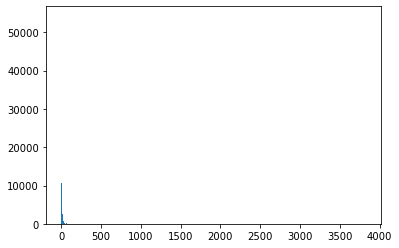

In [93]:
unique_hold_keys = sorted(unique_hold_times.keys())
print('Variatia timpului de asteptare: intre {} si {}'.format(unique_hold_keys[0], unique_hold_keys[-1]))
print('Media de eșantion: {}, moda: {}, mediana: {}, abaterea standartă: {}'.format(
    np.average(hold_times),
    stats.mode(hold_times),
    np.median(hold_times),
    np.std(hold_times)))
plt.bar(
    list(range(unique_hold_keys[0], unique_hold_keys[-1])),
    [unique_hold_times[x] for x in range(unique_hold_keys[0], unique_hold_keys[-1])])
plt.show()

După cum se vede, graficul timpului de așteptare de asemenea corespunde vag unei distribuții exponențiale. Vom folosi din nou tehnica z-score pentru a elimina valorile extrem de mari și a primi un grafic mai inteligibil.

In [94]:
filtered_hold_times = []
for i in zip(hold_times, stats.zscore(hold_times)):
    if abs(i[1]) < 3:
        filtered_hold_times.append(i[0])
print(len(filtered_hold_times))

131403


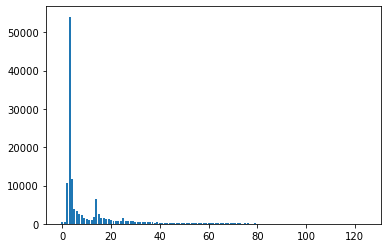

In [95]:
unique_hold_times = Counter(filtered_hold_times)
unique_hold_keys = sorted(unique_hold_times.keys())
plt.bar(
    list(range(unique_hold_keys[0], unique_hold_keys[-1])),
    [unique_hold_times[x] for x in range(unique_hold_keys[0], unique_hold_keys[-1])])
plt.show()

Numarul de apeluri din intervalul 00:00:00 - 00:30:00: 505


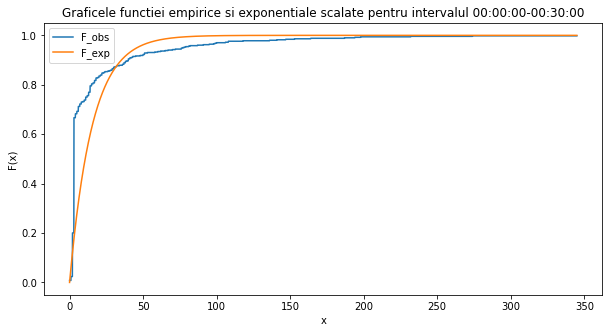

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 00:00:00 - 00:30:00: KstestResult(statistic=0.4886311509837339, pvalue=1.912654248602143e-111)
Numarul de apeluri din intervalul 00:30:00 - 01:00:00: 592


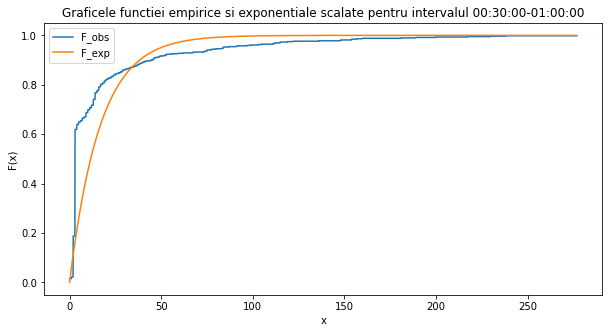

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 00:30:00 - 01:00:00: KstestResult(statistic=0.4540543050706513, pvalue=7.93667073883743e-112)
Numarul de apeluri din intervalul 01:00:00 - 01:30:00: 1025


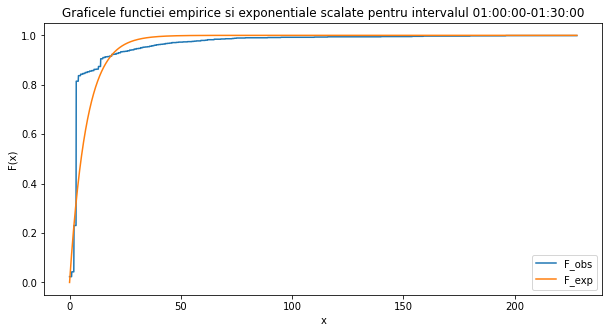

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 01:00:00 - 01:30:00: KstestResult(statistic=0.48414356552837673, pvalue=1.7016264429572365e-221)
Numarul de apeluri din intervalul 01:30:00 - 02:00:00: 1343


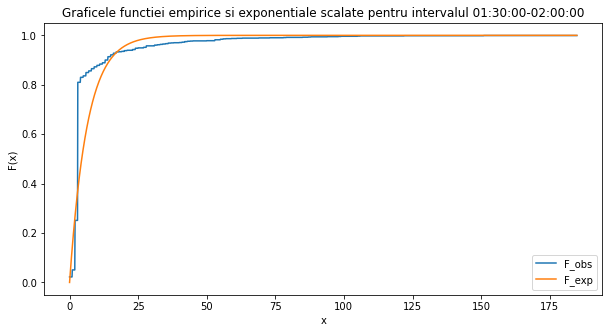

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 01:30:00 - 02:00:00: KstestResult(statistic=0.43526296923836616, pvalue=9.725272908883061e-232)
Numarul de apeluri din intervalul 02:00:00 - 02:30:00: 2627


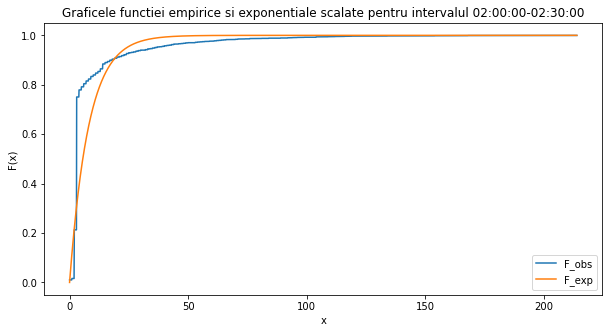

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 02:00:00 - 02:30:00: KstestResult(statistic=0.43897299384006433, pvalue=0.0)
Numarul de apeluri din intervalul 02:30:00 - 03:00:00: 2724


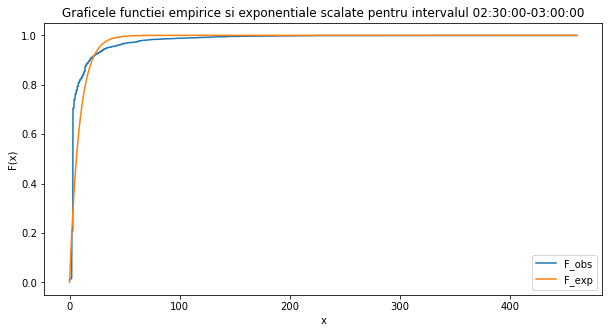

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 02:30:00 - 03:00:00: KstestResult(statistic=0.41947405857044323, pvalue=0.0)
Numarul de apeluri din intervalul 03:00:00 - 03:30:00: 3470


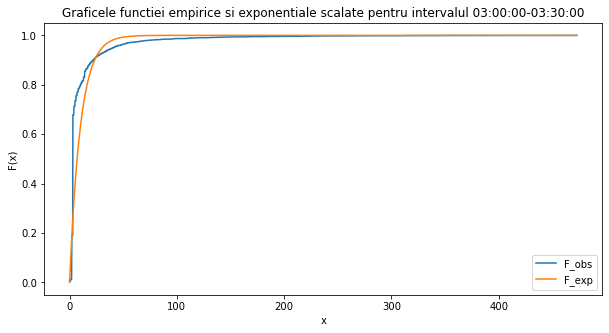

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 03:00:00 - 03:30:00: KstestResult(statistic=0.42289025391849056, pvalue=0.0)
Numarul de apeluri din intervalul 03:30:00 - 04:00:00: 3496


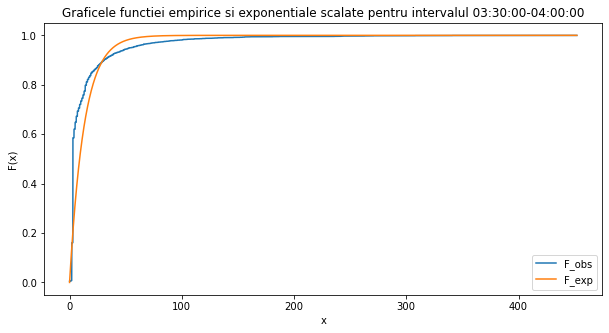

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 03:30:00 - 04:00:00: KstestResult(statistic=0.37803191969339855, pvalue=0.0)
Numarul de apeluri din intervalul 04:00:00 - 04:30:00: 4116


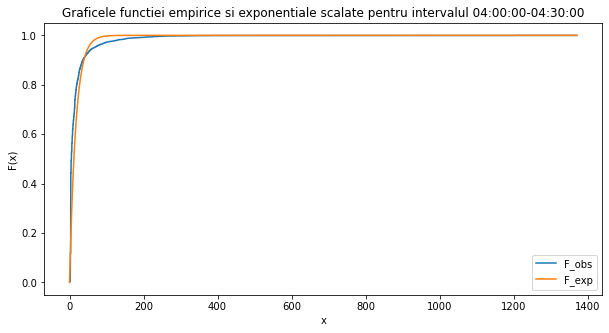

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 04:00:00 - 04:30:00: KstestResult(statistic=0.2825903914050303, pvalue=3.234926126011187e-291)
Numarul de apeluri din intervalul 04:30:00 - 05:00:00: 4207


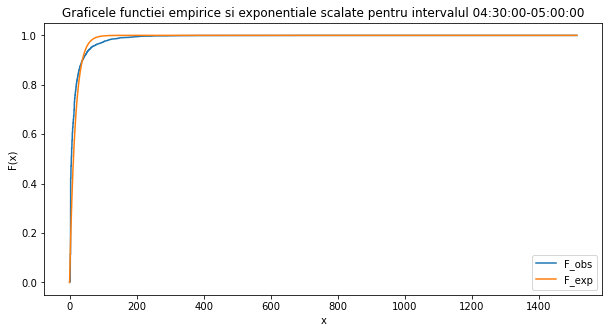

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 04:30:00 - 05:00:00: KstestResult(statistic=0.25762321818319917, pvalue=1.1528092164604183e-246)
Numarul de apeluri din intervalul 05:00:00 - 05:30:00: 5270


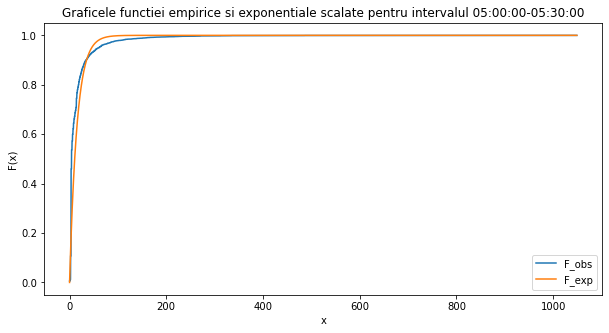

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 05:00:00 - 05:30:00: KstestResult(statistic=0.3064707844778021, pvalue=0.0)
Numarul de apeluri din intervalul 05:30:00 - 06:00:00: 5415


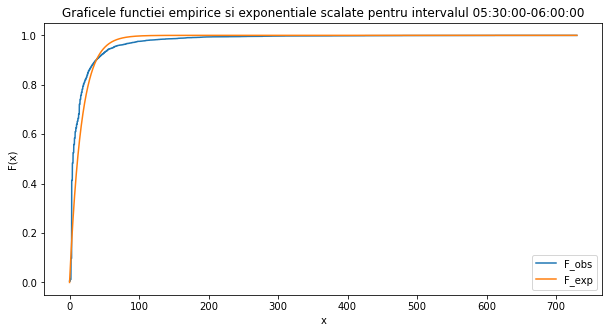

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 05:30:00 - 06:00:00: KstestResult(statistic=0.27056910391607125, pvalue=0.0)
Numarul de apeluri din intervalul 06:00:00 - 06:30:00: 6514


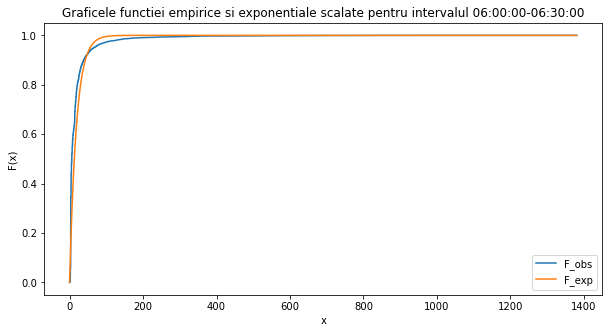

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 06:00:00 - 06:30:00: KstestResult(statistic=0.24938673219689175, pvalue=0.0)
Numarul de apeluri din intervalul 06:30:00 - 07:00:00: 6499


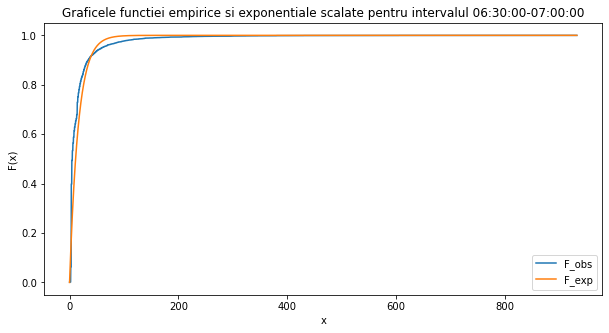

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 06:30:00 - 07:00:00: KstestResult(statistic=0.27244636009063405, pvalue=0.0)
Numarul de apeluri din intervalul 07:00:00 - 07:30:00: 6710


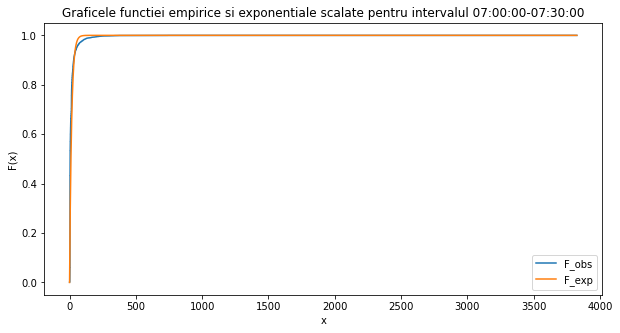

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 07:00:00 - 07:30:00: KstestResult(statistic=0.2963688245729754, pvalue=0.0)
Numarul de apeluri din intervalul 07:30:00 - 08:00:00: 6708


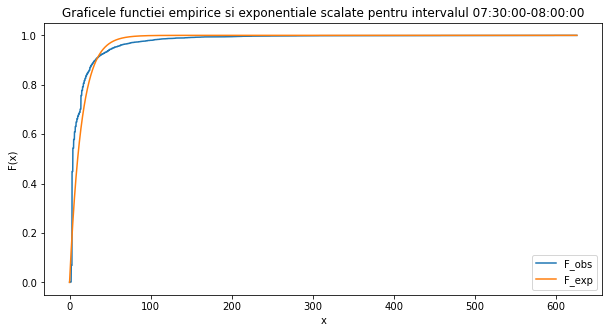

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 07:30:00 - 08:00:00: KstestResult(statistic=0.3005676281226016, pvalue=0.0)
Numarul de apeluri din intervalul 08:00:00 - 08:30:00: 6624


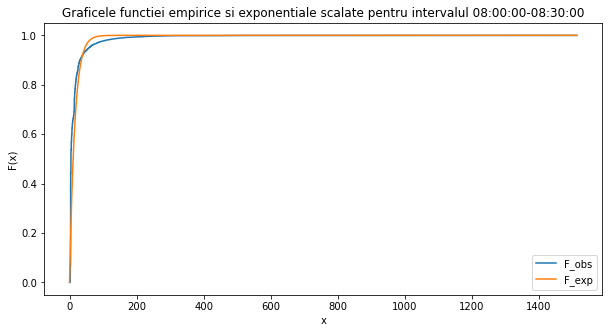

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 08:00:00 - 08:30:00: KstestResult(statistic=0.30447262367665856, pvalue=0.0)
Numarul de apeluri din intervalul 08:30:00 - 09:00:00: 6475


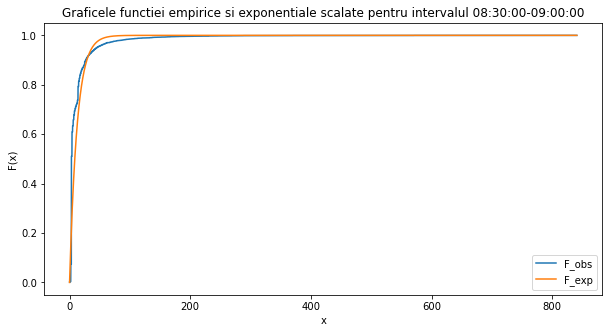

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 08:30:00 - 09:00:00: KstestResult(statistic=0.3345068863099458, pvalue=0.0)
Numarul de apeluri din intervalul 09:00:00 - 09:30:00: 6669


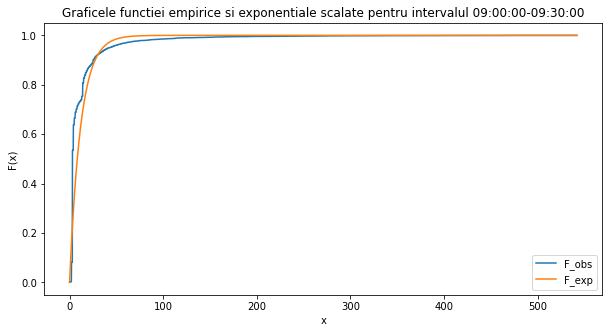

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 09:00:00 - 09:30:00: KstestResult(statistic=0.35195094027451784, pvalue=0.0)
Numarul de apeluri din intervalul 09:30:00 - 10:00:00: 6441


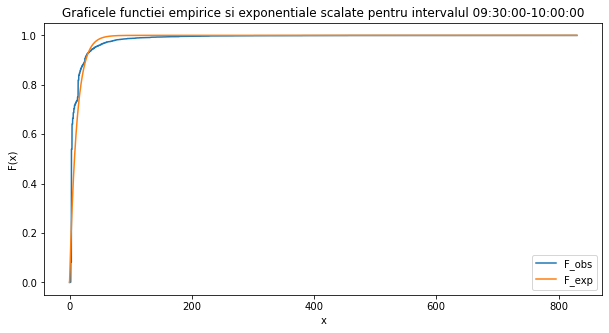

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 09:30:00 - 10:00:00: KstestResult(statistic=0.3475238242183134, pvalue=0.0)
Numarul de apeluri din intervalul 10:00:00 - 10:30:00: 5786


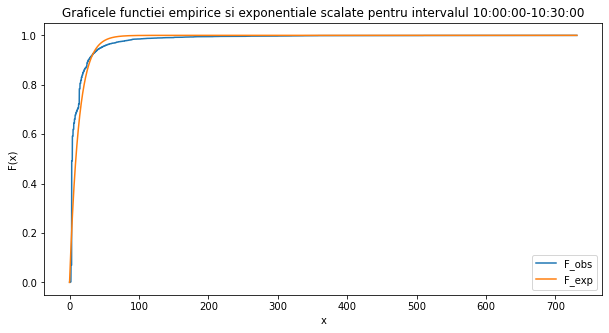

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 10:00:00 - 10:30:00: KstestResult(statistic=0.327675182238195, pvalue=0.0)
Numarul de apeluri din intervalul 10:30:00 - 11:00:00: 5494


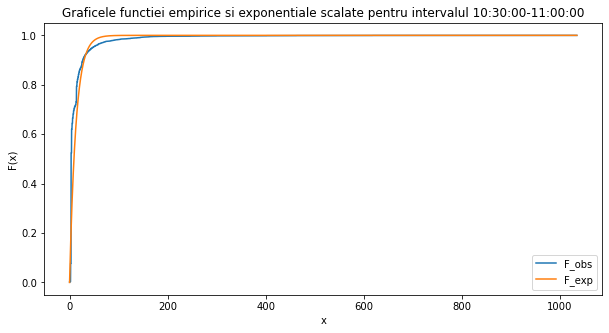

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 10:30:00 - 11:00:00: KstestResult(statistic=0.3536510569628943, pvalue=0.0)
Numarul de apeluri din intervalul 11:00:00 - 11:30:00: 5033


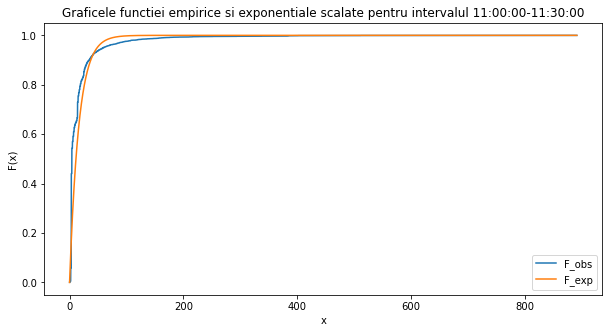

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 11:00:00 - 11:30:00: KstestResult(statistic=0.3238861690892795, pvalue=0.0)
Numarul de apeluri din intervalul 11:30:00 - 12:00:00: 4795


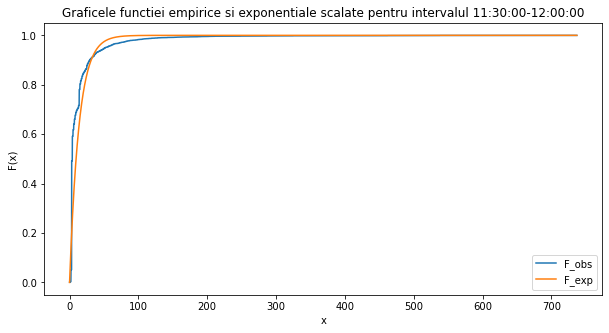

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 11:30:00 - 12:00:00: KstestResult(statistic=0.3373204466322961, pvalue=0.0)
Numarul de apeluri din intervalul 12:00:00 - 12:30:00: 4311


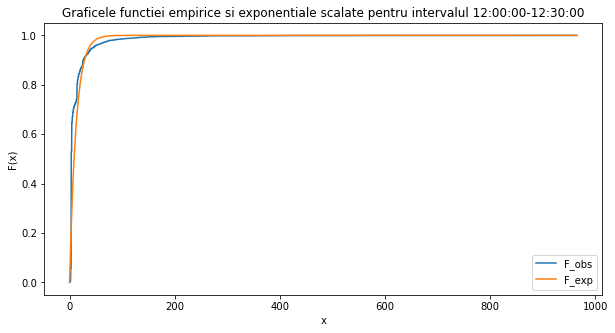

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 12:00:00 - 12:30:00: KstestResult(statistic=0.3705561465864498, pvalue=0.0)
Numarul de apeluri din intervalul 12:30:00 - 13:00:00: 4120


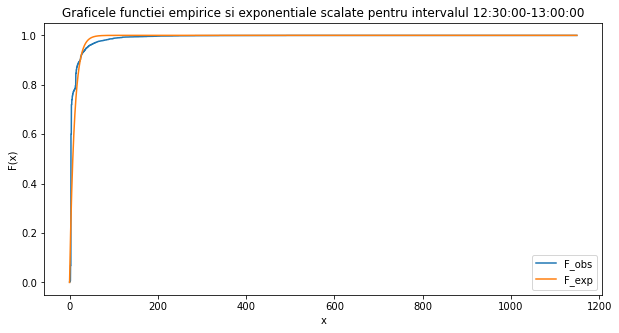

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 12:30:00 - 13:00:00: KstestResult(statistic=0.40403223771815705, pvalue=0.0)
Numarul de apeluri din intervalul 13:00:00 - 13:30:00: 3188


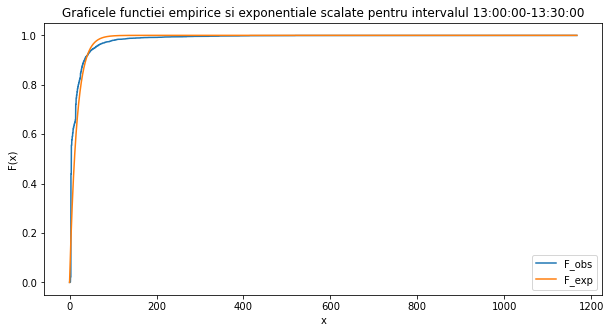

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 13:00:00 - 13:30:00: KstestResult(statistic=0.3373603038444527, pvalue=0.0)
Numarul de apeluri din intervalul 13:30:00 - 14:00:00: 2907


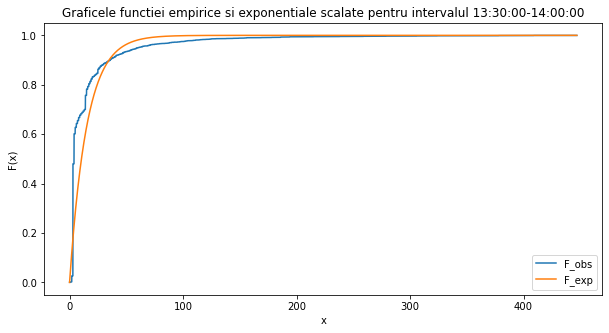

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 13:30:00 - 14:00:00: KstestResult(statistic=0.3688259158609282, pvalue=0.0)
Numarul de apeluri din intervalul 14:00:00 - 14:30:00: 2308


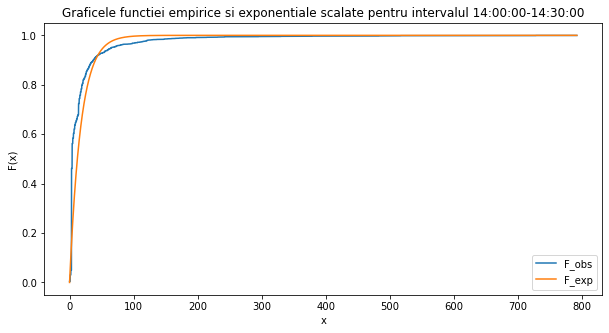

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 14:00:00 - 14:30:00: KstestResult(statistic=0.3582020203634838, pvalue=1.688264911363147e-265)
Numarul de apeluri din intervalul 14:30:00 - 15:00:00: 1980


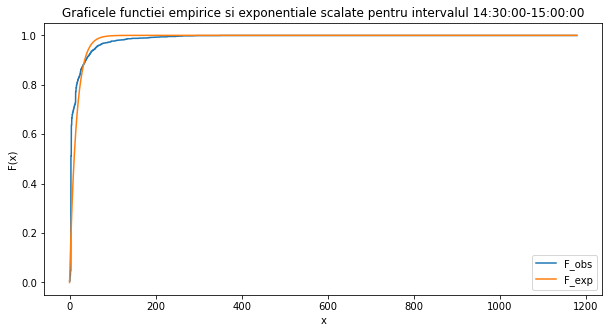

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 14:30:00 - 15:00:00: KstestResult(statistic=0.40644272616675065, pvalue=6.106484359924069e-296)
Numarul de apeluri din intervalul 15:00:00 - 15:30:00: 1520


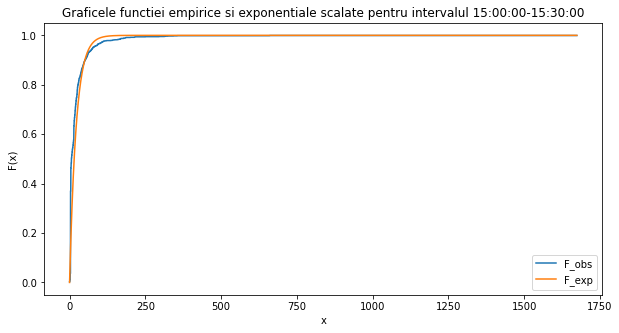

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 15:00:00 - 15:30:00: KstestResult(statistic=0.2965370748416726, pvalue=6.775108295988435e-119)
Numarul de apeluri din intervalul 15:30:00 - 16:00:00: 1249


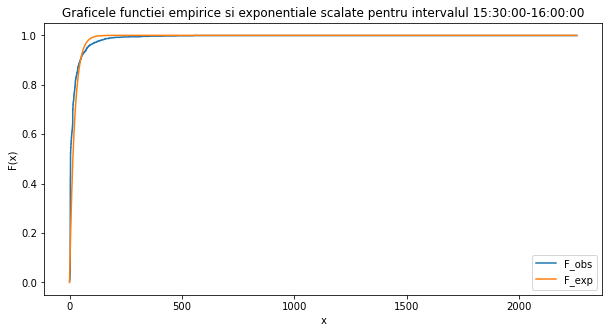

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 15:30:00 - 16:00:00: KstestResult(statistic=0.3538016778160357, pvalue=3.0148621996845824e-140)
Numarul de apeluri din intervalul 16:00:00 - 16:30:00: 849


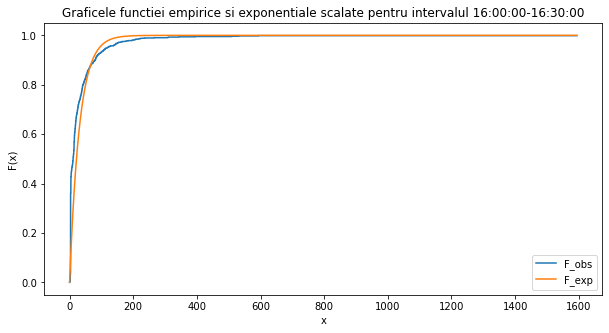

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 16:00:00 - 16:30:00: KstestResult(statistic=0.30794066241760654, pvalue=6.768474276055656e-72)
Numarul de apeluri din intervalul 16:30:00 - 17:00:00: 738


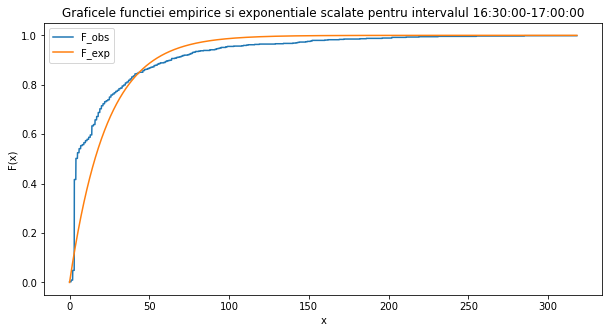

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 16:30:00 - 17:00:00: KstestResult(statistic=0.3421634680063356, pvalue=1.5624053976803901e-77)
Numarul de apeluri din intervalul 17:00:00 - 17:30:00: 490


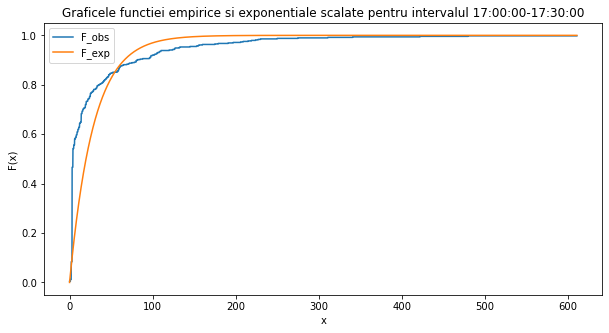

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 17:00:00 - 17:30:00: KstestResult(statistic=0.41138994846929344, pvalue=2.2230801413007296e-75)
Numarul de apeluri din intervalul 17:30:00 - 18:00:00: 359


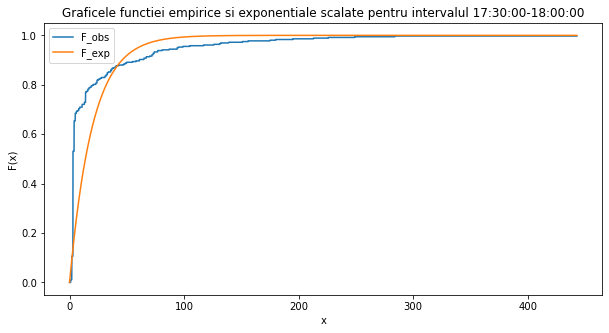

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 17:30:00 - 18:00:00: KstestResult(statistic=0.4716963939416767, pvalue=1.2979726204754109e-73)
Numarul de apeluri din intervalul 18:00:00 - 18:30:00: 3
Numarul de apeluri din intervalul 18:30:00 - 19:00:00: 1
Numarul de apeluri din intervalul 19:00:00 - 19:30:00: 3
Numarul de apeluri din intervalul 19:30:00 - 20:00:00: 1
Numarul de apeluri din intervalul 20:00:00 - 20:30:00: 1
Numarul de apeluri din intervalul 20:30:00 - 21:00:00: 1
Numarul de apeluri din intervalul 21:00:00 - 21:30:00: 1
Numarul de apeluri din intervalul 21:30:00 - 22:00:00: 1
Numarul de apeluri din intervalul 22:00:00 - 22:30:00: 2
Numarul de apeluri din intervalul 22:30:00 - 23:00:00: 102


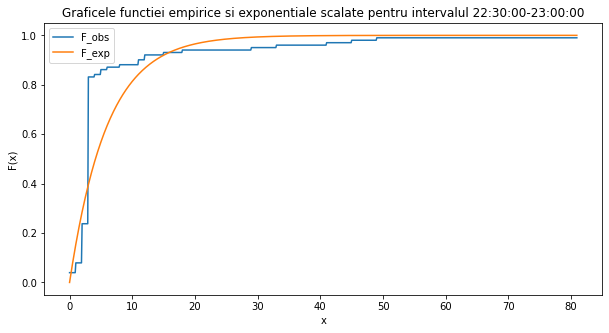

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 22:30:00 - 23:00:00: KstestResult(statistic=0.4356960622057072, pvalue=5.8928826021326494e-18)
Numarul de apeluri din intervalul 23:00:00 - 23:30:00: 268


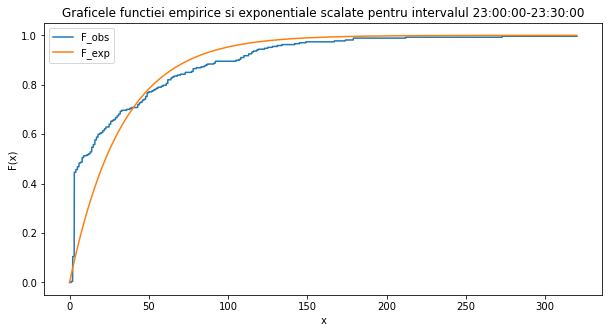

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 23:00:00 - 23:30:00: KstestResult(statistic=0.35802373686206124, pvalue=3.8248232407645812e-31)
Numarul de apeluri din intervalul 23:30:00 - 23:59:59: 281


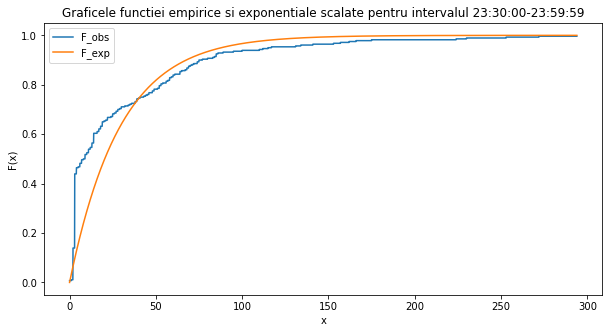

Rezultatele testului Kolmogorov-Smirnov pentru intervalul 23:30:00 - 23:59:59: KstestResult(statistic=0.34209898682478046, pvalue=9.31705926626853e-30)


In [100]:
def get_holdtime_values(first_day, last_day, interval_start, interval_end):
    """
    Returns interarrival values for a number of days between first_day and last_day
    for the hours between interval_start and interval_end
    """
    first_day = datetime.date.fromisoformat(first_day)
    last_day = datetime.date.fromisoformat(last_day)
    a_day = datetime.timedelta(hours=24)
    days = []
    hours = []
    temp_day = first_day
    while temp_day <= last_day:
        days.append(temp_day)
        temp_day += a_day
    
    intervals = []
    for day in days:
        calls = QueueCall.search([
            '|',
            ('last_status', '=', 'COMPLETECALLER'),
            ('last_status', '=', 'COMPLETEAGENT'),
            ('create_date', '>', '{} {}'.format(day.isoformat(), interval_start)),
            ('create_date','<','{} {}'.format(day.isoformat(), interval_end))]
        )
        # print('On {} we got {} calls'.format(day.isoformat(), len(calls)))
        # print(calls)
        for n in calls:
            intervals.append(float(QueueCall.browse(n).hold_time))
    return intervals


intervals = []
for hour in range(24):
    intervals.append(('{0:02d}:00:00'.format(hour),'{0:02d}:30:00'.format(hour)))
    if hour < 23:
        intervals.append(('{0:02d}:30:00'.format(hour),'{0:02d}:00:00'.format(hour+1)))
    else:
        intervals.append(('{0:02d}:30:00'.format(hour),'{0:02d}:59:59'.format(hour)))
    

for interval in intervals:
    interval_calls = get_holdtime_values(
        '2020-10-10', '2020-11-30', interval[0], interval[1])
    print('Numarul de apeluri din intervalul {} - {}: {}'.format(
        interval[0], interval[1], len(interval_calls)+1))
    if len(interval_calls) < 3:
        continue
    
    # Generate graph 
    x_vals = np.arange(0, max(interval_calls), 10**-1)
    average_rate = len(interval_calls)/sum(interval_calls)
    # print(average_rate)

    ecdf = ECDF(interval_calls)
    exp_dist = expon.cdf(x_vals, scale=1/average_rate)
    obs_dist = ecdf(x_vals)

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, obs_dist, label='F_obs')
    plt.plot(x_vals, exp_dist, label='F_exp')
    plt.legend()
    plt.ylabel("F(x)")
    plt.xlabel('x')
    plt.title("Graficele functiei empirice si exponentiale scalate pentru intervalul {}-{}".format(
        interval[0], interval[1]))
    plt.show()
    
    # Compute KS
    print('Rezultatele testului Kolmogorov-Smirnov pentru intervalul {} - {}: {}'.format(
        interval[0], interval[1],
        kstest(interval_calls, lambda x: expon.cdf(x, scale=1/average_rate))))

### Analiza duratei apelurilor

Variatia duratei apelurilor: intre 0 si 2502
Media de eșantion: 129.0546649855908, moda: ModeResult(mode=array([1]), count=array([2002])), mediana: 112.0, abaterea standartă: 108.1170002891905


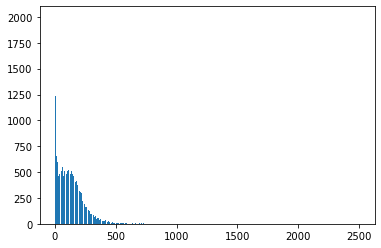

In [101]:

unique_talk_keys = sorted(unique_talk_times.keys())
print('Variatia duratei apelurilor: intre {} si {}'.format(unique_talk_keys[0], unique_talk_keys[-1]))
print('Media de eșantion: {}, moda: {}, mediana: {}, abaterea standartă: {}'.format(
    np.average(talk_times),
    stats.mode(talk_times),
    np.median(talk_times),
    np.std(talk_times)))
plt.bar(
    list(range(unique_talk_keys[0], unique_talk_keys[-1])),
    [unique_talk_times[x] for x in range(unique_talk_keys[0], unique_talk_keys[-1])])
plt.show()

După cum se vede, graficul duratei convorbirilor corespunde vag unei distribuții lognormale. Vom folosi din nou tehnica z-score pentru a elimina valorile extrem de mari și a primi un grafic mai inteligibil.

In [102]:
filtered_talk_times = []
for i in zip(talk_times, stats.zscore(talk_times)):
    if abs(i[1]) < 3:
        filtered_talk_times.append(i[0])
print(len(filtered_talk_times))

131545


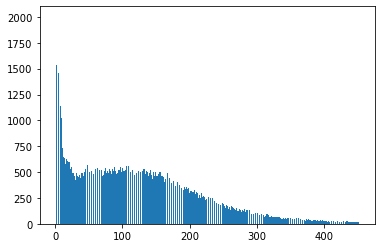

In [103]:
unique_talk_times = Counter(filtered_talk_times)
unique_talk_keys = sorted(unique_talk_times.keys())
plt.bar(
    list(range(unique_talk_keys[0], unique_talk_keys[-1])),
    [unique_talk_times[x] for x in range(unique_talk_keys[0], unique_talk_keys[-1])])
plt.show()

Deși graficul este apropiat funcției lognormale, vedem o denivelare la începutul graficului. Asemenea denivelare este caracteristică organizațiilor în care este prioritizată prelucrarea rapidă a apelurilor. Respectiv, pentru a îmbunătăți datele statistice legate de durata convorbirilor, operatorii des trișează - ei răspund apelului și îl termină foarte rapid. Astfel, media duratei apelurilor este menținută la valori reduse.

def get_holdtime_values(first_day, last_day, interval_start, interval_end):
    """
    Returns interarrival values for a number of days between first_day and last_day
    for the hours between interval_start and interval_end
    """
    first_day = datetime.date.fromisoformat(first_day)
    last_day = datetime.date.fromisoformat(last_day)
    a_day = datetime.timedelta(hours=24)
    days = []
    hours = []
    temp_day = first_day
    while temp_day <= last_day:
        days.append(temp_day)
        temp_day += a_day
    
    intervals = []
    for day in days:
        calls = QueueCall.search([
            '|',
            ('last_status', '=', 'COMPLETECALLER'),
            ('last_status', '=', 'COMPLETEAGENT'),
            ('create_date', '>', '{} {}'.format(day.isoformat(), interval_start)),
            ('create_date','<','{} {}'.format(day.isoformat(), interval_end))]
        )
        # print('On {} we got {} calls'.format(day.isoformat(), len(calls)))
        # print(calls)
        for n in calls:
            intervals.append(float(QueueCall.browse(n).call_duration))
    return intervals


intervals = []
for hour in range(24):
    intervals.append(('{0:02d}:00:00'.format(hour),'{0:02d}:30:00'.format(hour)))
    if hour < 23:
        intervals.append(('{0:02d}:30:00'.format(hour),'{0:02d}:00:00'.format(hour+1)))
    else:
        intervals.append(('{0:02d}:30:00'.format(hour),'{0:02d}:59:59'.format(hour)))
    

for interval in intervals:
    interval_calls = get_holdtime_values(
        '2020-10-10', '2020-11-30', interval[0], interval[1])
    print('Numarul de apeluri din intervalul {} - {}: {}'.format(
        interval[0], interval[1], len(interval_calls)+1))
    if len(interval_calls) < 3:
        continue
    
    # Generate graph 
    x_vals = np.arange(0, max(interval_calls), 10**-1)
    average_rate = len(interval_calls)/sum(interval_calls)
    # print(average_rate)

    ecdf = ECDF(interval_calls)
    exp_dist = expon.cdf(x_vals, scale=1/average_rate)
    obs_dist = ecdf(x_vals)

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, obs_dist, label='F_obs')
    plt.plot(x_vals, exp_dist, label='F_exp')
    plt.legend()
    plt.ylabel("F(x)")
    plt.xlabel('x')
    plt.title("Graficele functiei empirice si log-normale scalate pentru intervalul {}-{}".format(
        interval[0], interval[1]))
    plt.show()
    
    # Compute KS
    print('Rezultatele testului Kolmogorov-Smirnov pentru intervalul {} - {}: {}'.format(
        interval[0], interval[1],
        kstest(interval_calls, lambda x: expon.cdf(x, scale=1/average_rate))))